<table>
  <tr>
    <td style="border: none; padding-right: 20px;">
      <img src="logo_uni.png" width="300" style="margin: 0; padding: 0;">
    </td>
    <td style="border: none; vertical-align: middle;">
      <h1 style="margin: 0;">Airline Customer Segmentation</h1>
      <p style="margin: 0; font-size: 18px;">Master in Data Science - 2025/26</p>
      <p style="margin: 0; font-style: italic;">Developed by: <b>[Alexandre Coelho, 22222222], [Bruna Sousa, 20250526], [Rui Ferreira, 22222222] 
</b></p>
    </td>
  </tr>
</table>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from narwhals.stable.v1 import Datetime
from sklearn.cluster import KMeans, HDBSCAN, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from collections import Counter
import functions as func
from scipy.cluster.hierarchy import dendrogram

In [2]:
try:
    from functions import *
    print("SUCCESS: Custom functions loaded correctly from 'my_functions.py'.")
except ImportError:
    print("ERROR: Could not find 'my_functions.py'. Make sure the file is in the same folder as this notebook.")

SUCCESS: Custom functions loaded correctly from 'my_functions.py'.


## Table of Contents
- [Business Understanding](#business-understanding)
- [Data Understanding](#data-understanding)
  - [Customer Database](#customer-database)
    - [Reading the data](#reading-the-data)
    - [Metadata](#metadata)
    - [Initial Analysis](#initial-analysis)
    - [Data Quality Checks](#data-quality-checks)
  - [Flights Database](#flights-database)
    - [Reading the data](#reading-the-data-1)
    - [Metadata](#metadata-1)
    - [Initial Analysis](#initial-analysis-1)
    - [Data Quality Checks](#data-quality-checks-1)
- [Data Preparation](#data-preparation)
  - [Customers Database](#customers-database)
    - [Data Types](#data-types)
    - [Duplicates](#duplicates)
    - [Missing Values](#missing-values)
    - [Coherence Check](#coherence-check)
  - [Flights Database](#flights-database-1)
    - [Data Types](#data-types-1)
    - [Duplicates](#duplicates-1)
    - [Coherence Check](#coherence-check-1)
    - [Coherence Check on both databases](#coherence-check-on-both-databases)
- [Data Exploration](#data-exploration)
  - [Customer](#customer)
  - [Distributions of Categorical Features](#distributions-of-categorical-features)
  - [Distribution of Numerical Features](#distribution-of-numerical-features)

## 1. Business Understanding

AIAI aims to use customer data to understand their behaviors, with the goal of improving satisfaction, customer value, and profitability. The main challenge is to segment customers based on their travel habits and loyalty, enabling the creation of personalized marketing and optimized services. The project aims to transform these analytical findings into actionable business strategies.

## 2. Data Understanding

### 2.1 Customer Database

#### 2.1.1 Reading the data

In [3]:
customer_data = pd.read_csv("DM_AIAI_CustomerDB.csv",index_col=0)

#### 2.1.2 Metadata
- *Loyalty#* - Unique customer identifier for loyalty program members
- *First Name* - Customer's first name
- *Last Name* -	Customer's last name
- *Customer Name* - Customer's full name (concatenated)
- *Country* - Customer's country of residence
- *Province or State* - Customer's province or state
- *City* - Customer's city of residence
- *Latitude* - Geographic latitude coordinate of customer location
- *Longitude* - Geographic longitude coordinate of customer location
- *Postal code* - Customer's postal/ZIP code
- *Gender* - Customer's gender
- *Education* - Customer's highest education level (Bachelor, College, etc.)
- *Location Code*- Urban/Suburban/Rural classification of customer residence
- *Income* - Customer's annual income
- *Marital Status* - Customer's marital status (Married, Single, Divorced)
- *LoyaltyStatus* - Current tier status in loyalty program (Star > Nova > Aurora)
- *EnrollmentDateOpening* - Date when customer joined the loyalty program
- *CancellationDate* - Date when customer left the program
- *Customer Lifetime Value* - Total calculated monetary value of customer relationship
- *EnrollmentType* - Method of joining loyalty program


#### 2.1.3 Initial Analysis
General idea of the data structure, column names and types of values each variable contains.

In [4]:
customer = customer_data.copy()
customer.head(3)

,Loyalty#,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,Postal code,Gender,Education,Location Code,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType
0,480934,Cecilia,Householder,Cecilia Householder,Canada,Ontario,Toronto,43.653225,-79.383186,M2Z 4K1,female,Bachelor,Urban,70146.0,Married,Star,2/15/2019,NaN,3839.14,Standard
1,549612,Dayle,Menez,Dayle Menez,Canada,Alberta,Edmonton,53.544388,-113.490930,T3G 6Y6,male,College,Rural,0.0,Divorced,Star,3/9/2019,NaN,3839.61,Standard
2,429460,Necole,Hannon,Necole Hannon,Canada,British Columbia,Vancouver,49.282730,-123.120740,V6E 3D9,male,College,Urban,0.0,Single,Star,7/14/2017,1/8/2021,3839.75,Standard


In [5]:
print(f"Numbers of lines and columns: {customer.shape}")

Numbers of lines and columns: (16921, 20)


In [6]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16921 entries, 0 to 19
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Loyalty#                 16921 non-null  int64  
 1   First Name               16921 non-null  object 
 2   Last Name                16921 non-null  object 
 3   Customer Name            16921 non-null  object 
 4   Country                  16921 non-null  object 
 5   Province or State        16921 non-null  object 
 6   City                     16921 non-null  object 
 7   Latitude                 16921 non-null  float64
 8   Longitude                16921 non-null  float64
 9   Postal code              16921 non-null  object 
 10  Gender                   16921 non-null  object 
 11  Education                16921 non-null  object 
 12  Location Code            16921 non-null  object 
 13  Income                   16901 non-null  float64
 14  Marital Status           16921

In [7]:
customer.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Loyalty#,16921.0,NaN,NaN,NaN,550197.393771,259251.503597,100011.0,326823.0,550896.0,772438.0,999999.0
First Name,16921,4941,Stacey,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Last Name,16921,15404,Ypina,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Customer Name,16921,16921,Emma Martin,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country,16921,1,Canada,16921,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Province or State,16921,11,Ontario,5468,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,16921,29,Toronto,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Latitude,16921.0,NaN,NaN,NaN,47.1745,3.307971,42.984924,44.231171,46.087818,49.28273,60.721188
Longitude,16921.0,NaN,NaN,NaN,-91.814768,22.242429,-135.05684,-120.23766,-79.383186,-74.596184,-52.712578
Postal code,16921,75,V6E 3D9,917,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 2.1.4 Data Quality Checks

In [8]:
customer.replace("", np.nan, inplace=True)
customer.isna().sum()

Loyalty#                       0
First Name                     0
Last Name                      0
Customer Name                  0
Country                        0
Province or State              0
City                           0
Latitude                       0
Longitude                      0
Postal code                    0
Gender                         0
Education                      0
Location Code                  0
Income                        20
Marital Status                 0
LoyaltyStatus                  0
EnrollmentDateOpening          0
CancellationDate           14611
Customer Lifetime Value       20
EnrollmentType                 0
dtype: int64

We have 20 customers without income data, 20 customers without Customer Lifetime Value data and 14611 customers without CancellationDate data.

In [9]:
customer.duplicated().sum()

np.int64(0)

We have no duplicated rows in our data.

### 2.2 Flights Database

#### 2.2.1 Reading the data

In [10]:
flight_data = pd.read_csv("DM_AIAI_FlightsDB.csv")

#### 2.2.2 Metadata
- *Variable* - Description
- *Loyalty#* - Unique customer identifier linking to CustomerDB
- *Year* -	Year of flight activity record
- *Month* - Month of flight activity record (1-12)
- *YearMonthDate* - First day of the month for the activity period
- *NumFlights* - Total number of flights taken by customer in the month
- *NumFlightsWithCompanions* - Number of flights where customer traveled with companions
- *DistanceKM* - Total distance traveled in kilometers for the month
- *PointsAccumulated* - Loyalty points earned by customer during the month
- *PointsRedeemed* - Loyalty points spent/redeemed by customer during the month
- *DollarCostPointsRedeemed* - Dollar value of points redeemed during the month

#### 2.2.3 Initial Analysis

General idea of the data structure, column names and types of values each variable contains.

In [11]:
flight = flight_data.copy()
flight.head(3)

,Loyalty#,Year,Month,YearMonthDate,NumFlights,NumFlightsWithCompanions,DistanceKM,PointsAccumulated,PointsRedeemed,DollarCostPointsRedeemed
0,413052,2021,12,12/1/2021,2.0,2.0,9384.0,938.0,0.0,0.0
1,464105,2021,12,12/1/2021,0.0,0.0,0.0,0.0,0.0,0.0
2,681785,2021,12,12/1/2021,10.0,3.0,14745.0,1474.0,0.0,0.0


In [12]:
print(f"Numbers of lines and columns: {flight.shape}")

Numbers of lines and columns: (608436, 10)


In [13]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608436 entries, 0 to 608435
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Loyalty#                  608436 non-null  int64  
 1   Year                      608436 non-null  int64  
 2   Month                     608436 non-null  int64  
 3   YearMonthDate             608436 non-null  object 
 4   NumFlights                608436 non-null  float64
 5   NumFlightsWithCompanions  608436 non-null  float64
 6   DistanceKM                608436 non-null  float64
 7   PointsAccumulated         608436 non-null  float64
 8   PointsRedeemed            608436 non-null  float64
 9   DollarCostPointsRedeemed  608436 non-null  float64
dtypes: float64(6), int64(3), object(1)
memory usage: 46.4+ MB


In [14]:
flight.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Loyalty#,608436.0,NaN,NaN,NaN,550037.873084,258935.180575,100018.0,326961.0,550834.0,772194.0,999986.0
Year,608436.0,NaN,NaN,NaN,2020.0,0.816497,2019.0,2019.0,2020.0,2021.0,2021.0
Month,608436.0,NaN,NaN,NaN,6.5,3.452055,1.0,3.75,6.5,9.25,12.0
YearMonthDate,608436,36,12/1/2021,16901,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NumFlights,608436.0,NaN,NaN,NaN,3.908107,5.057889,0.0,0.0,0.0,7.2,21.0
NumFlightsWithCompanions,608436.0,NaN,NaN,NaN,0.983944,2.003785,0.0,0.0,0.0,0.9,11.0
DistanceKM,608436.0,NaN,NaN,NaN,7939.341419,10260.421873,0.0,0.0,856.4,15338.175,42040.0
PointsAccumulated,608436.0,NaN,NaN,NaN,793.777781,1025.918521,0.0,0.0,85.275,1533.7125,4204.0
PointsRedeemed,608436.0,NaN,NaN,NaN,235.251678,983.233374,0.0,0.0,0.0,0.0,7496.0
DollarCostPointsRedeemed,608436.0,NaN,NaN,NaN,2.324835,9.725168,0.0,0.0,0.0,0.0,74.0


#### 2.2.4 Data Quality Checks

In [15]:
flight.replace("", np.nan, inplace=True)
flight.isna().sum()

Loyalty#                    0
Year                        0
Month                       0
YearMonthDate               0
NumFlights                  0
NumFlightsWithCompanions    0
DistanceKM                  0
PointsAccumulated           0
PointsRedeemed              0
DollarCostPointsRedeemed    0
dtype: int64

We have no missing data.

In [16]:
flight.duplicated().sum()

np.int64(2903)

We have 2903 duplicated rowns in our data, that we will look at later.

## 3. Data Preparation

### 3.1 Customers Database

#### 3.1.1 Data Types

In [17]:
customer.dtypes

Loyalty#                     int64
First Name                  object
Last Name                   object
Customer Name               object
Country                     object
Province or State           object
City                        object
Latitude                   float64
Longitude                  float64
Postal code                 object
Gender                      object
Education                   object
Location Code               object
Income                     float64
Marital Status              object
LoyaltyStatus               object
EnrollmentDateOpening       object
CancellationDate            object
Customer Lifetime Value    float64
EnrollmentType              object
dtype: object

The Enrollment Date Opening and Cancellation Dates can be converted to datetime type.

In [18]:
customer["EnrollmentDateOpening"] = pd.to_datetime(customer["EnrollmentDateOpening"])
customer["CancellationDate"] = pd.to_datetime(customer["CancellationDate"], errors="coerce")

#### 3.1.2 Duplicates

To use the 'Loyalty#' column as the dataframe's index, it was essential to first confirm that it contained only unique values. An index acts as a primary key for data retrieval, and duplicate entries would make this unreliable.

Upon inspection, some 'Loyalty#' IDs were found to be duplicated. Since there was no clear way to determine which entry represented the true customer record (the "source of truth"), the most robust decision was to remove all records associated with these ambiguous IDs. This data cleansing step ensures the integrity of the dataset, leaving only customers with a single, unique 'Loyalty#' identifier, which can now be reliably set as the index.

In [19]:
duplicated_loyalty = customer_data.duplicated(subset=['Loyalty#'], keep=False)
duplicated_loyalty_list = customer_data[duplicated_loyalty]['Loyalty#'].unique()
print(f"Duplicated Loyaltys {len(duplicated_loyalty_list)}")
customer = customer[customer['Loyalty#'].isin(duplicated_loyalty_list) == False]
print(f"For the initial customer data we have {len(customer_data)} records.\n"
      f"We identified {len(duplicated_loyalty_list)} 'Loyalty#' IDs that were duplicated or appears repeatedly.\n"
      f"So the final len of the data set is {len(customer)}.")

Duplicated Loyaltys 163
For the initial customer data we have 16921 records.
We identified 163 'Loyalty#' IDs that were duplicated or appears repeatedly.
So the final len of the data set is 16594.


In [20]:
customer.set_index("Loyalty#", inplace=True)

#### 3.1.3 Missing Values

In [21]:
customer[customer["Income"].isna()].tail(3)

,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,Postal code,Gender,Education,Location Code,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType
Loyalty#,,,,,,,,,,,,,,,,,,,
100014,Amelia,Bennett,Amelia Bennett,Canada,New Brunswick,Moncton,46.051866,-64.825428,G2S 2B6,male,Bachelor,Rural,NaN,Married,Star,2020-11-28,2020-11-28,NaN,Standard
100015,Benjamin,Wilson,Benjamin Wilson,Canada,Quebec,Quebec City,46.862970,-71.133444,B1Z 8T3,female,College,Urban,NaN,Married,Star,2020-04-09,2020-04-09,NaN,Standard
100016,Emma,Martin,Emma Martin,Canada,British Columbia,Dawson Creek,55.720562,-120.160090,M4A 1E4,female,Master,Suburban,NaN,Single,Star,2020-07-21,2020-07-21,NaN,Standard


The customers with missing income information also have a Customer Lifetime Value equal to 0, which we believe is because their cancellation date is the same as their enrollment date, and it has no value for the company.

In [22]:
customer_NaN_income = customer["Income"].isna().mean() * 100
print(f"The percentage of customers with missing data about income is {customer_NaN_income:.2f} %.")

The percentage of customers with missing data about income is 0.12 %.


Because the percentage of missing data about income is 0.12 %, it is safe to remove this rows.

In [23]:
customer = customer.dropna(subset=['Income'])


#### 3.1.4 Coherence Check

In [24]:
# Number of customers with available values in cancellation date
total_cancel_dates = len(customer[customer["CancellationDate"].notna()])
print(f"Number of available cancellation dates: {total_cancel_dates} ({((total_cancel_dates/len(customer))*100):.2f}%)")

Number of available cancellation dates: 2245 (13.55%)


Missing values in the CancellationDate column (which affects 86.45% of the customer base) are assumed to represent customers who have never officially terminated their loyalty membership. 

In [25]:
# Number of customers with cancelation date before the enrollment date
incoherent_cancel_dates = len(customer[customer['CancellationDate'] < customer['EnrollmentDateOpening']])
print(f"Number of incoherent dates: {incoherent_cancel_dates} ({((incoherent_cancel_dates/total_cancel_dates)*100):.2f}%)")

Number of incoherent dates: 199 (8.86%)


The 199 incoherent dates (CancellationDate < EnrollmentDateOpening) strongly suggest a business scenario where members re-enrolled in the loyalty program. It is possible that the CancellationDate reflects an old membership end,  while EnrollmentDateOpening records the start of their current re-activated membership.

This group represents a valuable segment of returned customers,  which we should give special attention during the segmentation phase. 

In [26]:
# Number of incoherent enrollment type 
cust_2021_promo = customer[customer["EnrollmentType"] == "2021 Promotion"].copy()
cust_2021_promo["EnrollmentYear"] = cust_2021_promo["EnrollmentDateOpening"].dt.year
incoherent_enrollment_type = cust_2021_promo[cust_2021_promo["EnrollmentYear"] !=2021.0]
print(f"Number of incoherent enrollment type (enrollment out of 2021): {len(incoherent_enrollment_type)}")

Number of incoherent enrollment type (enrollment out of 2021): 172


This check was performed to verify if the categorical feature "2021 Promotion" in EnrollmentType was chronologically coherent with the customer's EnrollmentDateOpening. The result shows that 172 of customers tagged with the "2021 Promotion" were registered in earlier years (2015, 2017,...).

The EnrollmentType variable remains useful for demographic/psychographic segmentation (identifying customers sensitive to incentives), but its value cannot be strictly relied upon for calculating customer longevity.

In [27]:
# Number of customer's names that don´t correspond to concatenation of first name and last name
coherent_names = ( customer["First Name"].str.strip()+" "+customer["Last Name"].str.strip())
incoherent_names_condition = (customer["Customer Name"].str.strip() != coherent_names.str.strip())
incoherent_names = customer[incoherent_names_condition]
print(f"Number of unmatched customer names: {len(incoherent_names)}")

Number of unmatched customer names: 0


Furthermore, comparing Customer Name against the concatenation of First Name and Last Name confirmed zero inconsistencies, demonstrating the perfect integrity of the customer identification fields.

### 3.2 Flights Database

#### 3.2.1 Data Types

In [28]:
flight.dtypes

Loyalty#                      int64
Year                          int64
Month                         int64
YearMonthDate                object
NumFlights                  float64
NumFlightsWithCompanions    float64
DistanceKM                  float64
PointsAccumulated           float64
PointsRedeemed              float64
DollarCostPointsRedeemed    float64
dtype: object

We decided to change the data types of variables NumFlights, NumFlightsWithCompanions, PointsAccumulated and PointsRedeemed to integers because these variables are discrete.
Also, the YearMonthDate variable can be converted to datetime type.

In [29]:
flight['YearMonthDate'] = pd.to_datetime(flight['YearMonthDate'], errors='coerce')

columns_to_convert = ["NumFlights", "NumFlightsWithCompanions", "PointsAccumulated", "PointsRedeemed"]
flight[columns_to_convert] = flight[columns_to_convert].astype(int)
print(flight[columns_to_convert].dtypes)

NumFlights                  int64
NumFlightsWithCompanions    int64
PointsAccumulated           int64
PointsRedeemed              int64
dtype: object


#### 3.2.2 Duplicates

Following the removal of ambiguous 'Loyalty#' IDs from the customer dataset, the same filtering was applied to the flight dataset. This step was crucial for maintaining referential integrity, as it ensures that the flight data only contains records for customers who are verifiably present in the customer data.

In [30]:
flight = flight[flight['Loyalty#'].isin(duplicated_loyalty_list) == False]

In [31]:
flight.duplicated().sum()

np.int64(0)

Interestingly, this action also resolved all duplicate issues within the flight dataset, indicating that the duplicated entries were tied to the same problematic 'Loyalty#' IDs. This clean-up ensures both datasets are now consistent and aligned.

#### 3.2.3 Coherence Checks

In [32]:
# Number of flights uncoherent
print(f"Number of uncoherent number of flights: {len(flight[flight["NumFlightsWithCompanions"] > flight["NumFlights"]])}")

# Number of flights with uncoherent data of DistanceKM
print(f"Number of uncoherent number of KMs: {len(flight[flight["DistanceKM"] < flight["NumFlights"]])}")

# Number of points accumulated with 0 KM travelled
incoherent_points_condition = (flight["PointsAccumulated"] >0) & (flight["DistanceKM"] == 0)
incoherent_points = flight[incoherent_points_condition]
print(f"Number of incoherent points accumulated: {len(incoherent_points)}")

# Number of incoherent points redeemed or dollar cost points redeemed
incoherent_dollars_condition = (flight["PointsRedeemed"]>0) & (flight["DollarCostPointsRedeemed"]==0) | (flight["PointsRedeemed"]==0) & (flight["DollarCostPointsRedeemed"]>0)
incoherent_dollars = flight[incoherent_dollars_condition]
print(f"Number of incoherent dollars redeemed: {len(incoherent_dollars)}")

Number of uncoherent number of flights: 0
Number of uncoherent number of KMs: 0
Number of incoherent points accumulated: 0
Number of incoherent dollars redeemed: 0


The flight activity data demonstrates high internal coherence, with zero records showing logical inconsistencies between flight counts, distance traveled, point accumulation and dollar cost of points redeemed.

### 3.3 Coherence Check on both databases

In [33]:
# Number of incoherent customers flying after customer cancelling the membership
cust_cancelled = customer[customer["CancellationDate"].notna()].copy()

merged_flights_cust_cancel = pd.merge(
    customer[customer["CancellationDate"].notna()][["CancellationDate", "EnrollmentDateOpening"]],
    flight[["Loyalty#", "YearMonthDate", "NumFlights"]],
    left_index=True, right_on= "Loyalty#", how="inner"
)

flights_condition1 = (
    (merged_flights_cust_cancel["YearMonthDate"]> merged_flights_cust_cancel["CancellationDate"]) &
    (merged_flights_cust_cancel["NumFlights"]>0) &
    (merged_flights_cust_cancel["EnrollmentDateOpening"]<=merged_flights_cust_cancel["CancellationDate"])
)

flights1 = merged_flights_cust_cancel[flights_condition1]
print(f"Number of incoherent customers flying after customer cancelling the membership: {flights1["Loyalty#"].nunique()}")

Number of incoherent customers flying after customer cancelling the membership: 0


This test verified if any customer registered flight activity after their official cancellation date without having subsequently re-enrolled in the loyalty program. The results showed zero unique customers exhibiting this true logical incoherence. The previously observed post-cancellation activity is fully justified by customer re-enrollment, meaning the old CancellationDate simply serves as a historical record rather than a current status flag.

In [34]:
customer["CancellationDate"] = customer["CancellationDate"].fillna(pd.Timestamp("1904-01-01"))

dizer que agora sim mudamos o type do cancellation date 

## 4. Data Exploration

### 4.1 Customer Database

#### 4.1.1 Distribution of Categorical Features

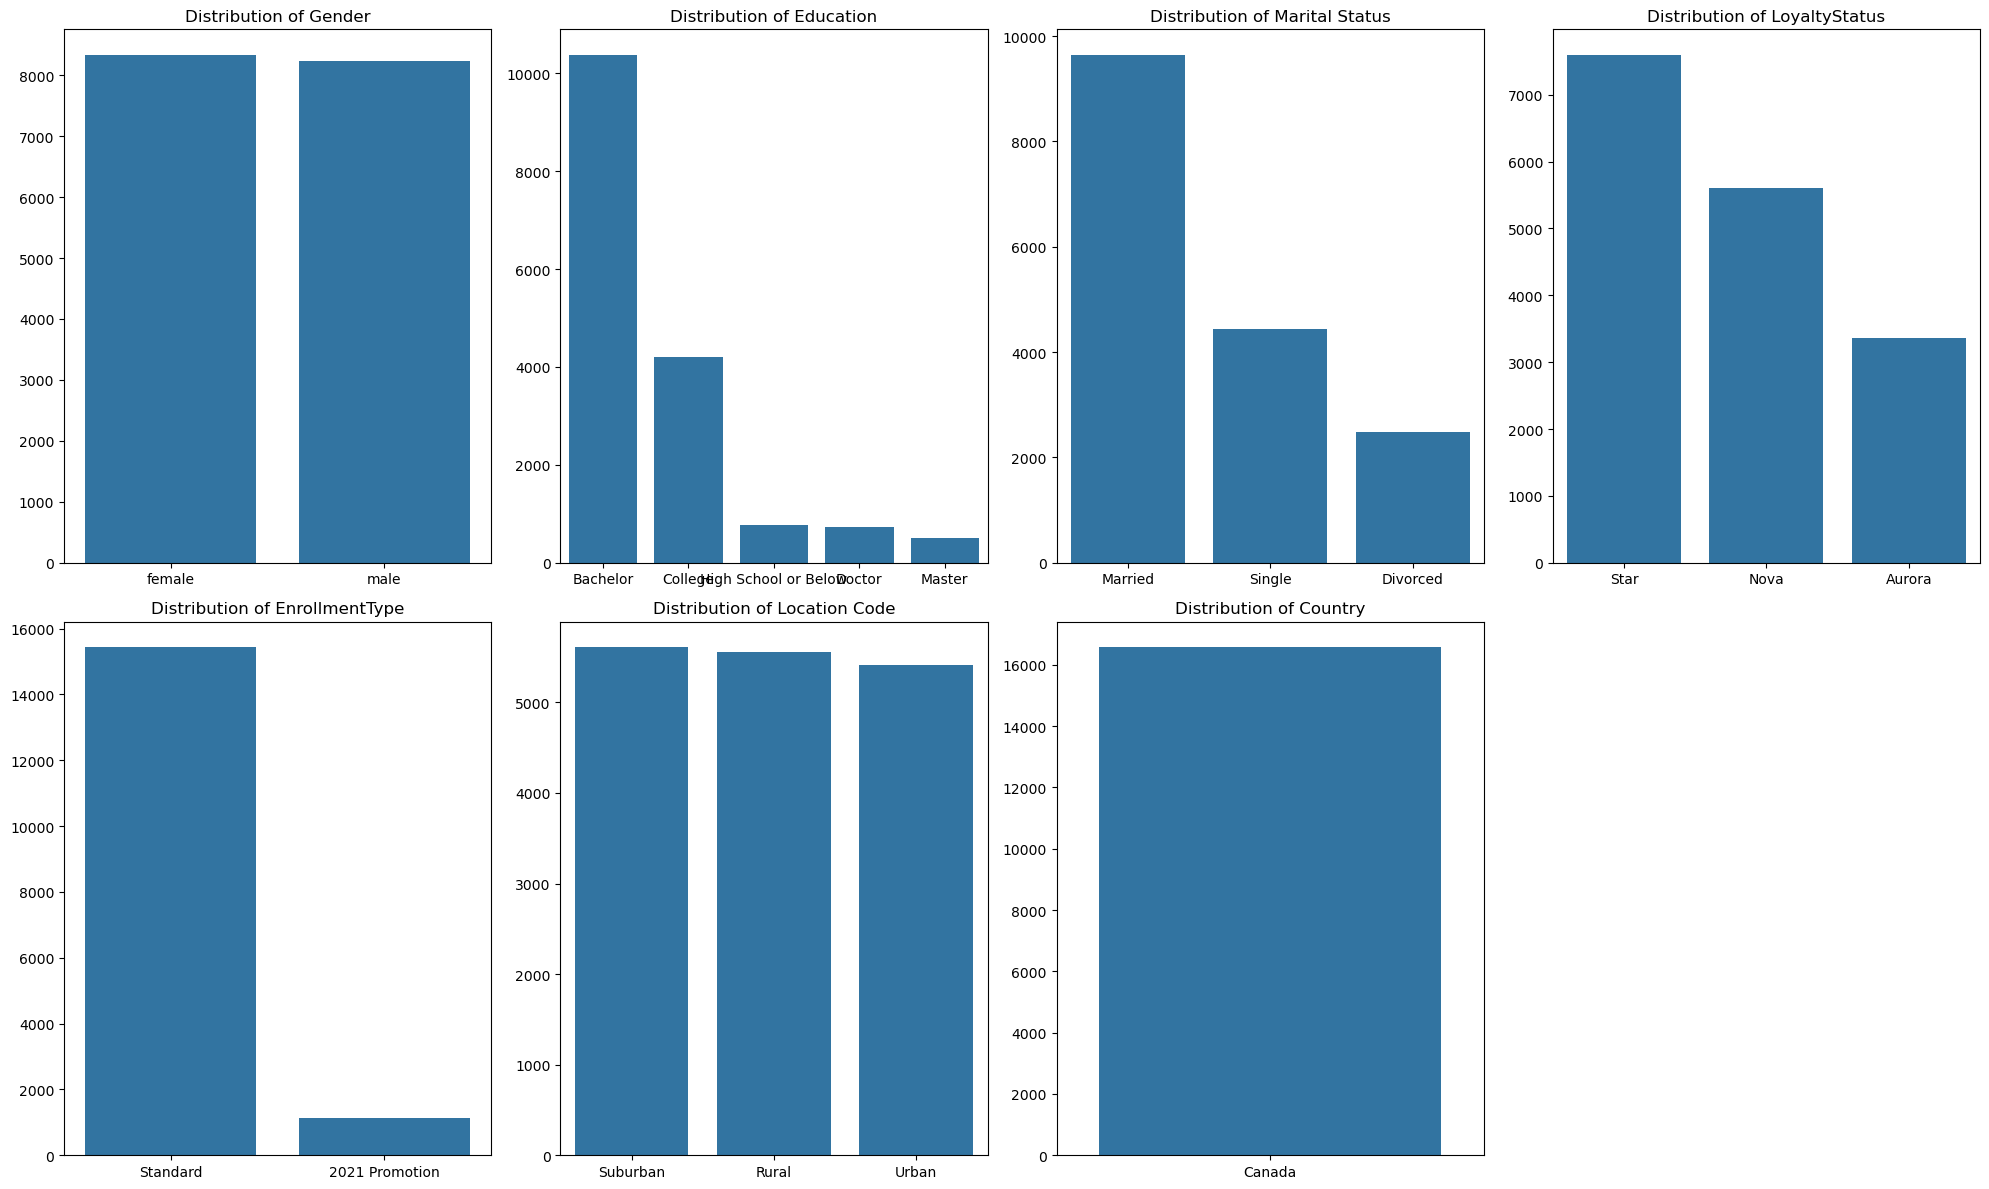

In [35]:

categorical_customer = ["Gender", "Education", "Marital Status", "LoyaltyStatus", "EnrollmentType", "Location Code","Country"]

plt.figure(figsize=(20, 12))
for i, col in enumerate(categorical_customer, 1):
    plt.subplot(2, 4, i)
    sns.countplot(x=col, data=customer, order=customer[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xlabel("")
    plt.ylabel("")
plt.tight_layout()
plt.show()


From these visualizations, we observe that the dataset shows no meaningful variation in gender or location type, suggesting that these variables may have limited discriminative power for segmentation.
Regarding education, the majority of loyalty members hold a Bachelor’s degree, followed by those with College-level education.
In terms of marital status, most customers are married, which may indicate a stable and mature demographic segment.
The loyalty status distribution reveals that most clients belong to the Star tier, followed by Nova and Aurora, highlighting a concentration in mid-level membership.
Finally, the enrollment type indicates that the majority of customers joined through the Standard enrollment process, which could suggest limited participation in promotional or referral programs.


#### 4.1.2 Distribution of Numerical Features

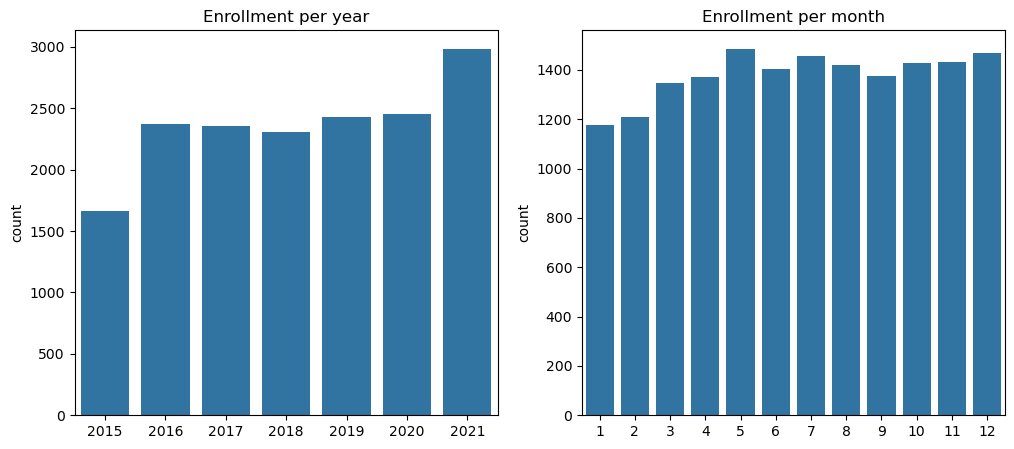

,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,Postal code,Gender,Education,Location Code,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType
Loyalty#,,,,,,,,,,,,,,,,,,,
480934,Cecilia,Householder,Cecilia Householder,Canada,Ontario,Toronto,43.653225,-79.383186,M2Z 4K1,female,Bachelor,Urban,70146.0,Married,Star,2019-02-15,1904-01-01,3839.14,Standard
549612,Dayle,Menez,Dayle Menez,Canada,Alberta,Edmonton,53.544388,-113.490930,T3G 6Y6,male,College,Rural,0.0,Divorced,Star,2019-03-09,1904-01-01,3839.61,Standard
429460,Necole,Hannon,Necole Hannon,Canada,British Columbia,Vancouver,49.282730,-123.120740,V6E 3D9,male,College,Urban,0.0,Single,Star,2017-07-14,2021-01-08,3839.75,Standard


In [36]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=customer["EnrollmentDateOpening"].dt.year, data=customer)
plt.title("Enrollment per year")
plt.xlabel("")

plt.subplot(1, 2, 2)
sns.countplot(x=customer["EnrollmentDateOpening"].dt.month, data=customer)
plt.title("Enrollment per month")
plt.xlabel("")
plt.show()
customer.head(3)

The analysis of enrollment trends shows a stable customer acquisition rate between 2016 and 2020, followed by a significant surge in 2021, which represents the highest volume of new enrollments within the dataset. This latest growth suggests successful recent marketing or promotional efforts and indicates a healthy expansion of the customer base. 2021 Promotion

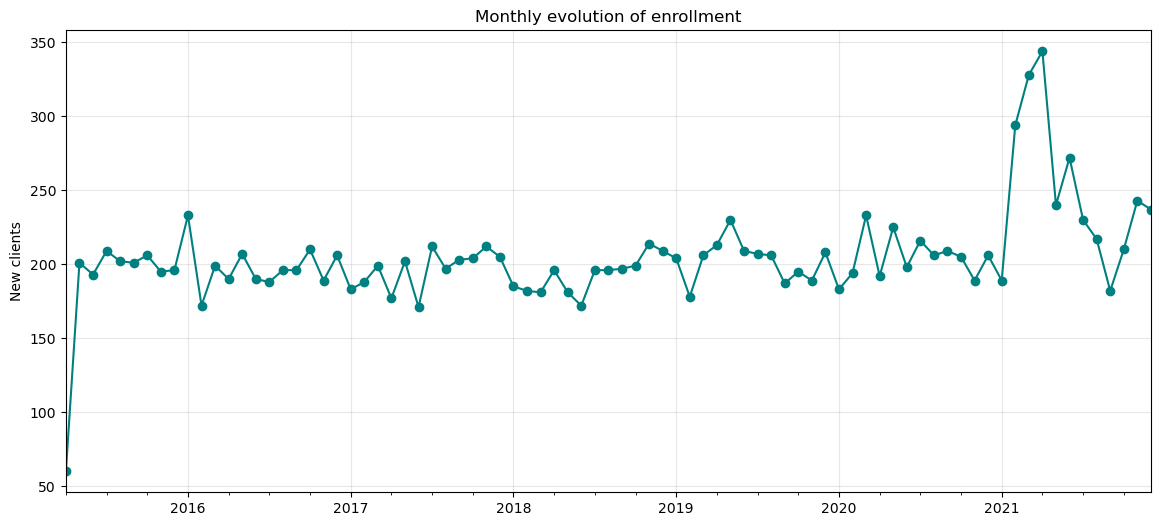

In [37]:
monthly_enrollments = customer.groupby(customer["EnrollmentDateOpening"].dt.to_period("M")).size().sort_index()
# converter índice PeriodIndex para timestamp para plot ficar com labels de datas
monthly_enrollments.index = monthly_enrollments.index.to_timestamp()

plt.figure(figsize=(14, 6))
monthly_enrollments.plot(kind='line', marker='o', color='teal')
plt.title("Monthly evolution of enrollment")
plt.xlabel("")
plt.ylabel("New clients")
plt.grid(True, alpha=0.3)
plt.show()

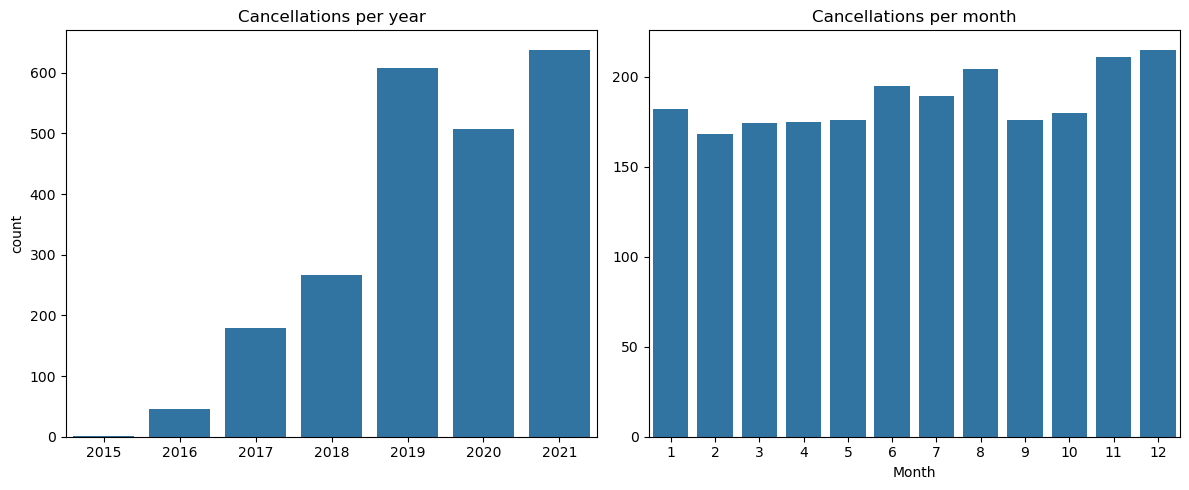

In [38]:

valid_dates = customer["CancellationDate"].dt.year != 1904


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(x=customer.loc[valid_dates, "CancellationDate"].dt.year.astype(int).sort_values())
plt.title("Cancellations per year")
plt.xlabel("")

plt.subplot(1,2,2)
sns.countplot(x=customer.loc[valid_dates, "CancellationDate"].dt.month.astype(int))
plt.title("Cancellations per month")
plt.xlabel("Month")
plt.ylabel("")
plt.tight_layout()

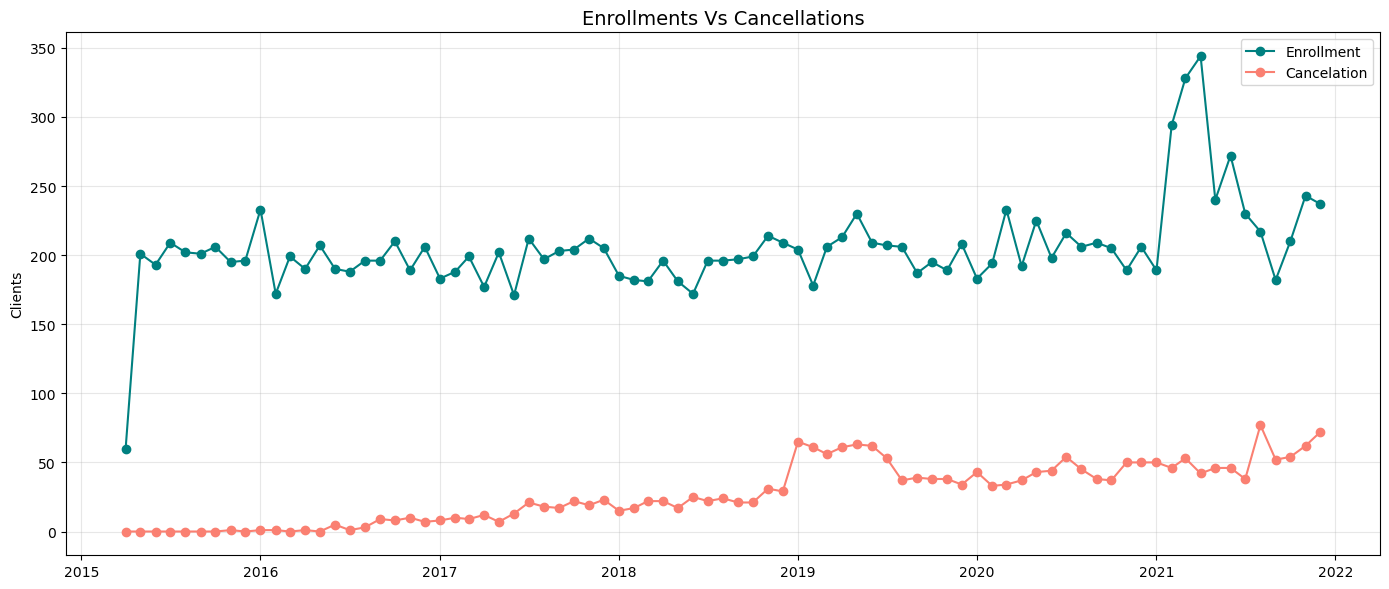

In [39]:
monthly_enroll = customer.groupby(customer["EnrollmentDateOpening"].dt.to_period("M")).size()
monthly_cancel = customer.loc[valid_dates].groupby(customer.loc[valid_dates, "CancellationDate"].dt.to_period("M")).size()

# Criar range completo de meses para alinhar as séries
all_months = pd.period_range(
    start=min(monthly_enroll.index.min(), monthly_cancel.index.min()),
    end=max(monthly_enroll.index.max(), monthly_cancel.index.max()),
    freq="M"
)

# Reindexar para garantir continuidade
monthly_enroll = monthly_enroll.reindex(all_months, fill_value=0)
monthly_cancel = monthly_cancel.reindex(all_months, fill_value=0)

# Converter PeriodIndex em datetime (para eixo legível)
monthly_enroll.index = monthly_enroll.index.to_timestamp()
monthly_cancel.index = monthly_cancel.index.to_timestamp()

plt.figure(figsize=(14,6))
plt.plot(monthly_enroll.index, monthly_enroll, marker='o', label="Enrollment", color='teal')
plt.plot(monthly_cancel.index, monthly_cancel, marker='o', label="Cancelation", color='salmon')
plt.title("Enrollments Vs Cancellations", fontsize=14)
plt.xlabel("")
plt.ylabel("Clients")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


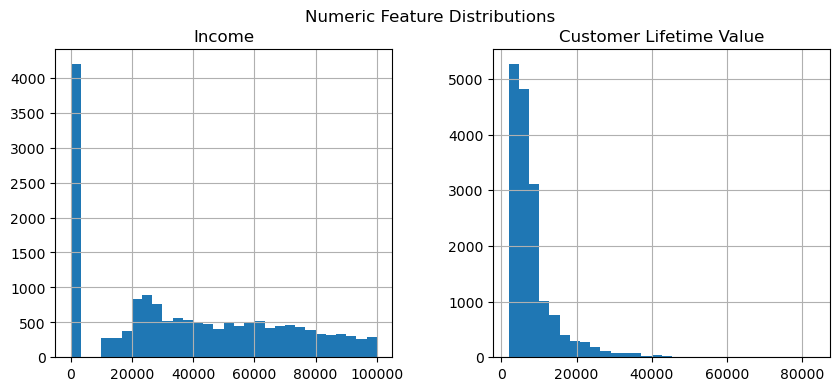

In [40]:
numeric_customer = ["Income", "Customer Lifetime Value"]
customer[numeric_customer].hist(bins=30 ,figsize=(10,4))
plt.suptitle("Numeric Feature Distributions")
plt.show()


The distributions of Income and Customer Lifetime Value are highly right-skewed, with the vast majority of customers concentrated at low values. The presence of a long tail suggests potential high-value customers, but these instances should be investigated to determine if they represent a genuine business segment (e.g., corporate clients) or data outliers.


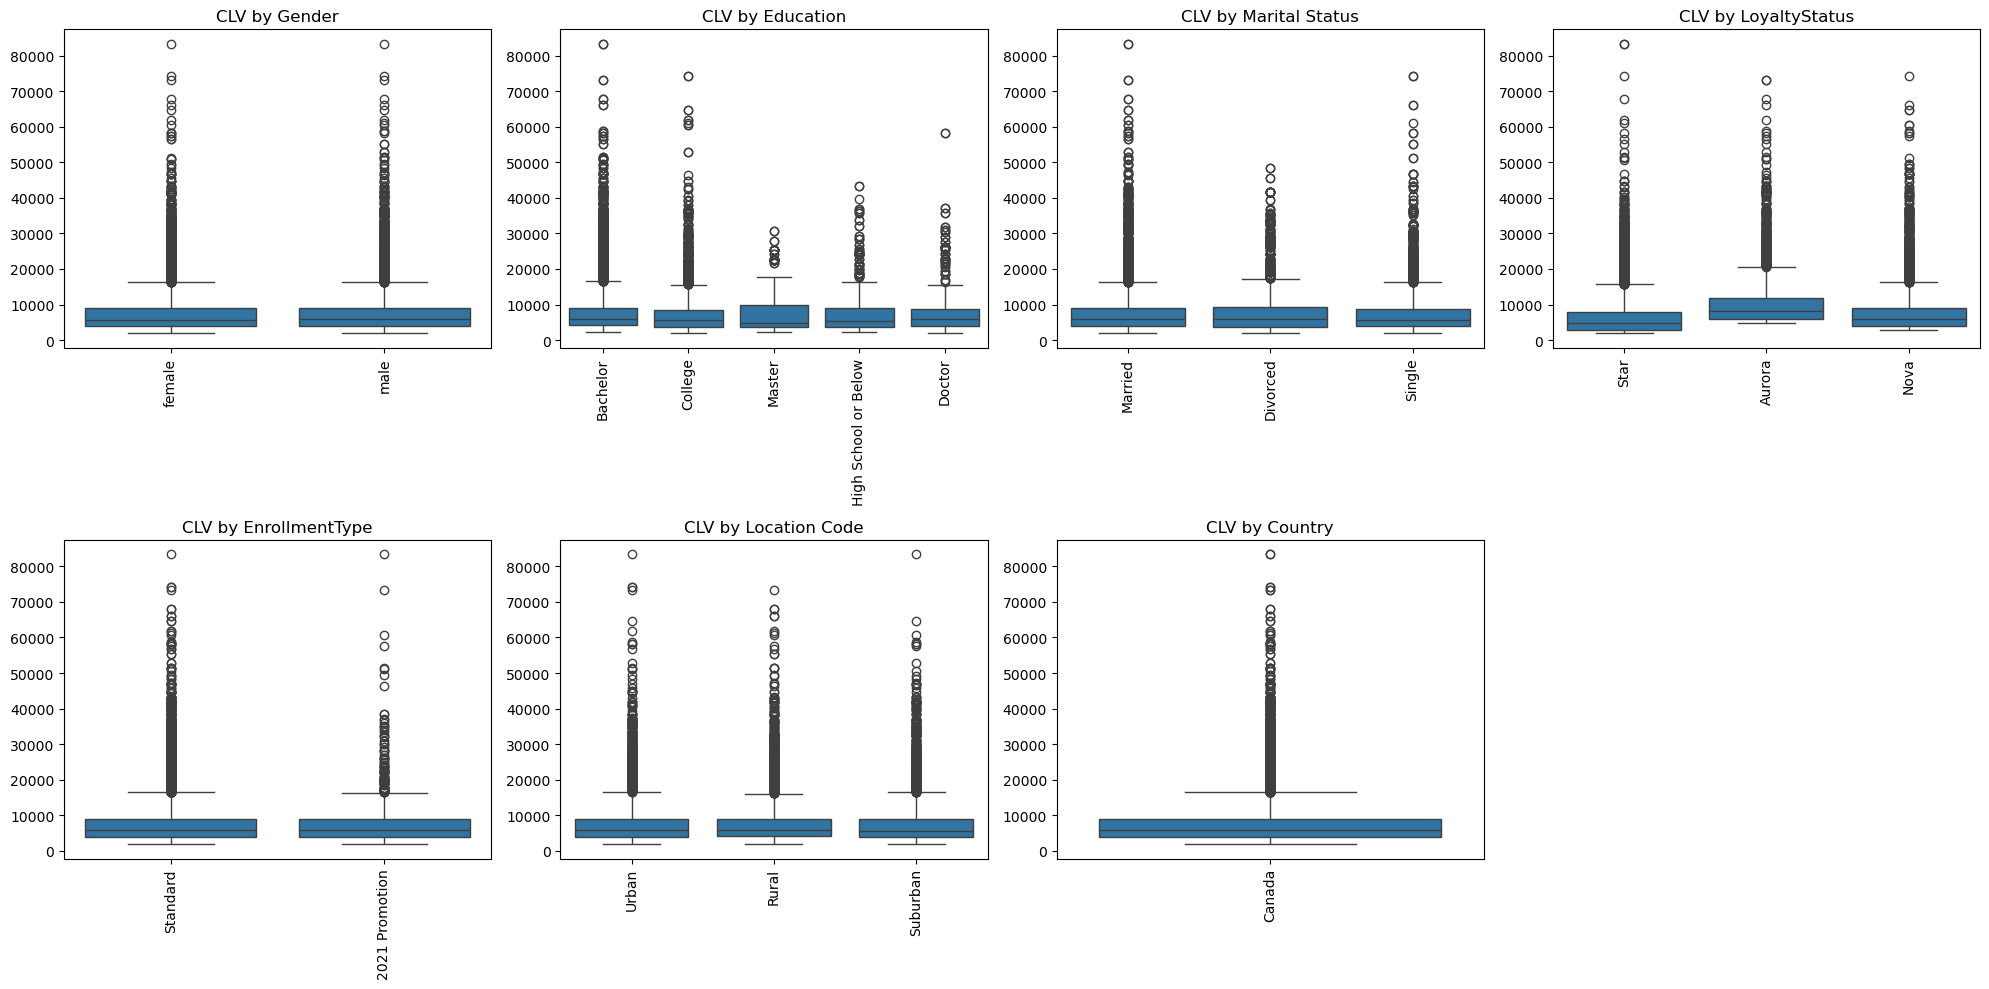

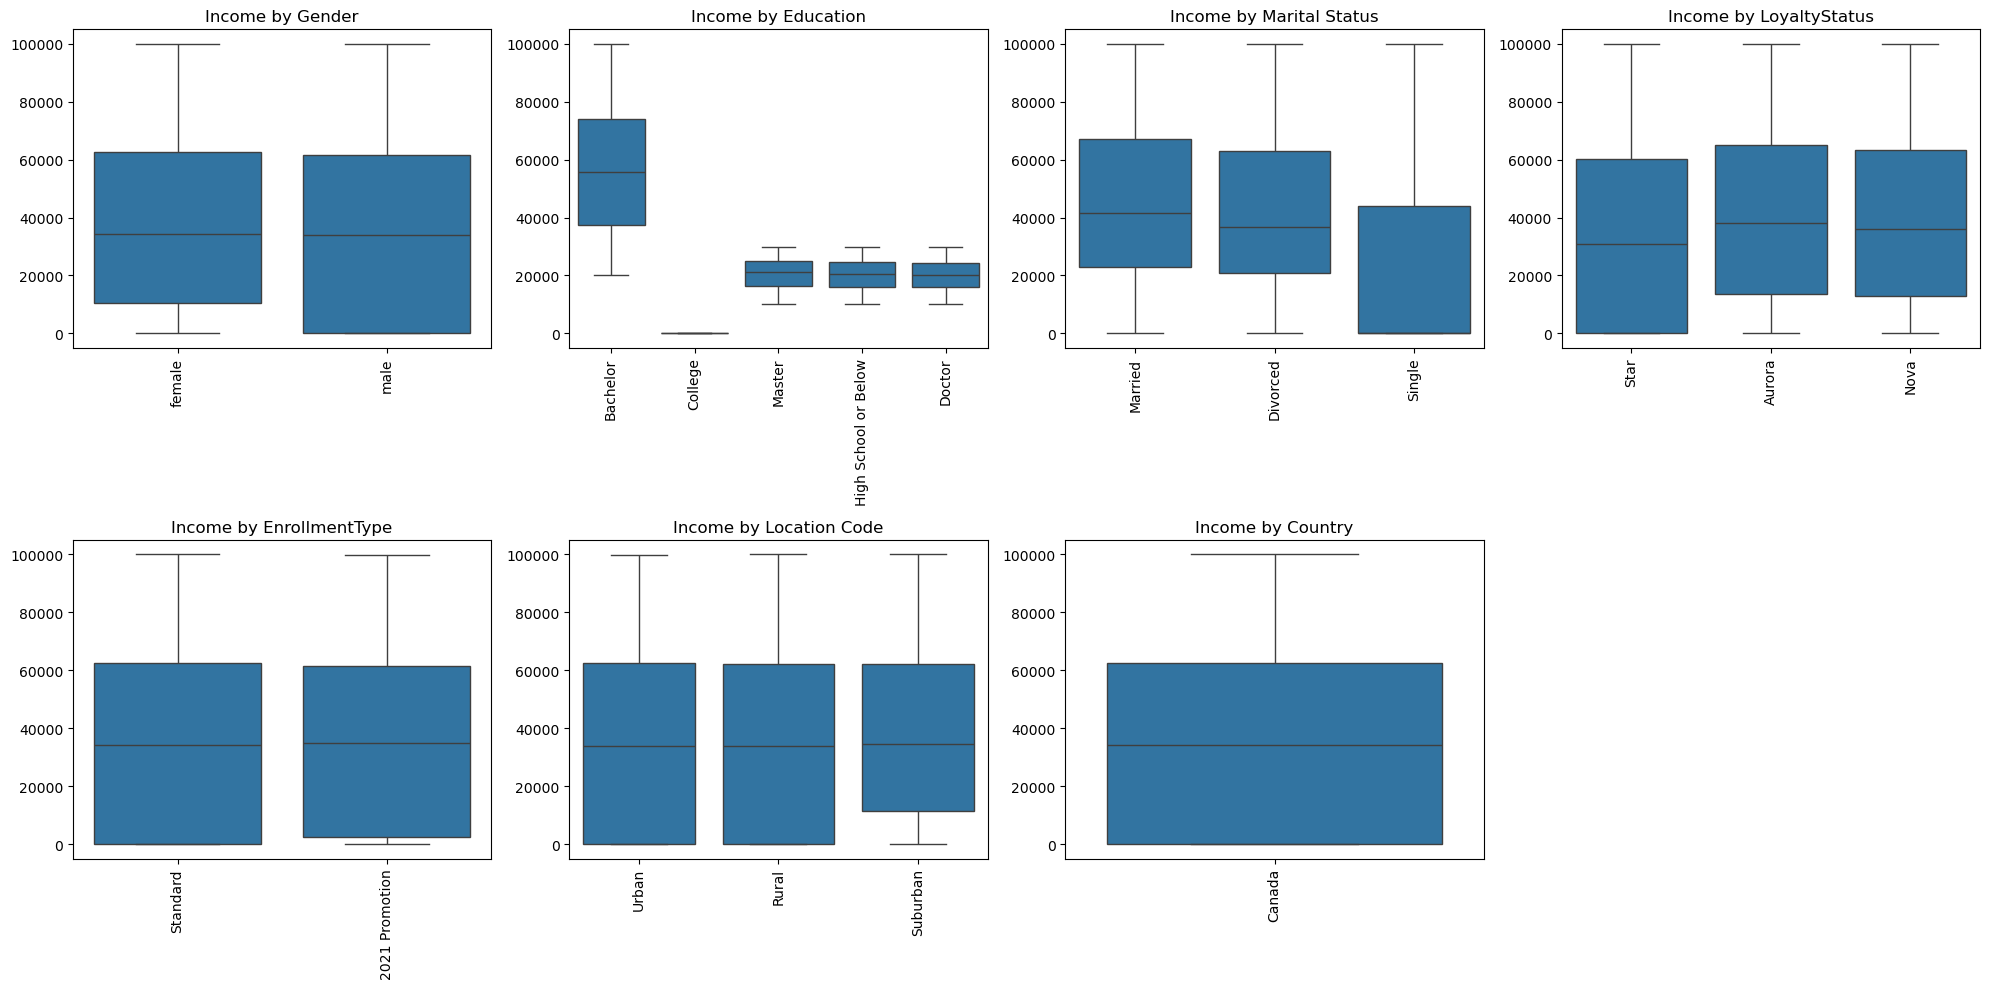

In [41]:
plt.figure(figsize=(20, 10))
for i, cat_col in enumerate(categorical_customer, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x=cat_col, y="Customer Lifetime Value", data=customer)
    plt.title(f"CLV by {cat_col}")
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 10))
for i, cat_col in enumerate(categorical_customer, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x=cat_col, y="Income", data=customer)
    plt.title(f"Income by {cat_col}")
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [42]:
def find_group_outliers(df, group_col, value_col, k=1.5):
    outlier_idx = []
    for name, g in df.groupby(group_col):
        q1 = g[value_col].quantile(0.25)
        q3 = g[value_col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - k * iqr
        upper = q3 + k * iqr
        mask = (g[value_col] < lower) | (g[value_col] > upper)
        outlier_idx.extend(g[mask].index.tolist())
    return df.loc[outlier_idx]

def outliers_for_all(df, cat_cols, value_cols=("Customer Lifetime Value", "Income"), k=1.5):
    results = {}
    for val in value_cols:
        print(f"\n--- {val} ---")
        # compute outliers per categorical column
        for col in cat_cols:
            out = find_group_outliers(df, col, val, k=k)
            results[(col, val)] = out
            print(f"{col}: {len(out)} outliers")
    return results

outliers_dict = outliers_for_all(customer, categorical_customer)



--- Customer Lifetime Value ---
Gender: 1463 outliers
Education: 1477 outliers
Marital Status: 1446 outliers
LoyaltyStatus: 1355 outliers
EnrollmentType: 1460 outliers
Location Code: 1445 outliers
Country: 1460 outliers

--- Income ---
Gender: 0 outliers
Education: 0 outliers
Marital Status: 0 outliers
LoyaltyStatus: 0 outliers
EnrollmentType: 0 outliers
Location Code: 0 outliers
Country: 0 outliers


**Income Distribution by Loyalty Status**

The median Income is similar but slightly lower for the Star loyalty group compared to Aurora and Nova. However, the overall distribution and range of Income across all three groups are highly consistent, with the Interquartile Ranges (IQR) and whiskers spanning similar values (from approximately $0 to $100,000). This suggests that Loyalty Status is not a strong differentiator of customer income levels.

**Customer liftime value by Loyalty Status**

The plot shows that high-CLV customers (outliers) are not segregated within a single, premium loyalty status; they are present across all three loyalty statuses (Star, Aurora, and Nova). While the Aurora tier shows a slightly higher median CLV, the overall pattern suggests that Loyalty Status is a poor predictor of a customer's lifetime value.

**Income Distribution by Education Level**
The analysis reveals that a Bachelor's degree is the dominant factor determining high customer income, with this group showing a significantly higher median and broader Interquartile Range (IQR) than all others. In contrast, Master's, High School, and Doctor levels show consistently low and similar median incomes. Crucially, the College category displays a median income of zero, pointing to a severe data quality issue (missing or improperly coded income values) that must be addressed prior to any predictive modeling.

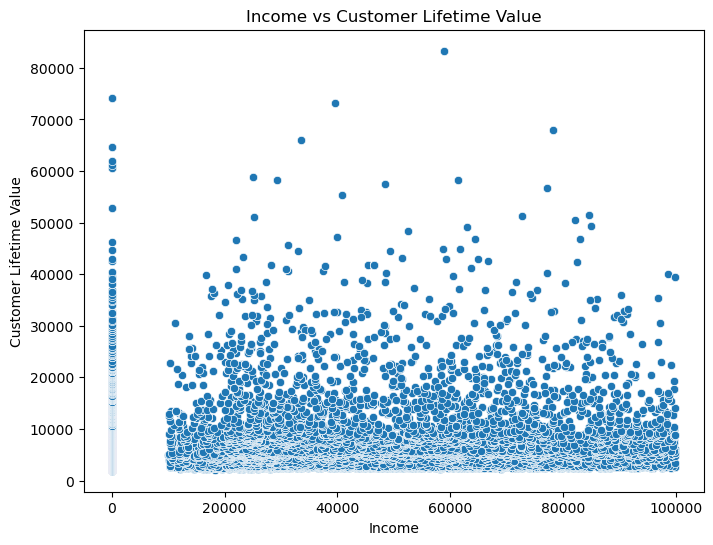

In [43]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Income', y='Customer Lifetime Value', data=customer)
plt.title('Income vs Customer Lifetime Value')
plt.show()

The scatter plot confirms that there is no strong linear correlation between Income and Customer Lifetime Value (CLV). High-CLV customers (the upper outliers) are observed across the entire income spectrum, demonstrating that a customer's purchasing power is not the primary driver of their long-term value. This suggests that predictive models should prioritize behavioral features over income.

### 4.2 Flights Database

In [44]:
flight.describe().T

,count,mean,min,25%,50%,75%,max,std
Loyalty#,596664.0,549435.680825,100018.0,326234.0,550020.0,771901.0,999986.0,258867.195581
Year,596664.0,2020.0,2019.0,2019.0,2020.0,2021.0,2021.0,0.816497
Month,596664.0,6.5,1.0,3.75,6.5,9.25,12.0,3.452055
YearMonthDate,596664,2020-06-16 02:40:00.000000768,2019-01-01 00:00:00,2019-09-23 12:00:00,2020-06-16 00:00:00,2021-03-08 18:00:00,2021-12-01 00:00:00,NaN
NumFlights,596664.0,3.845372,0.0,0.0,0.0,7.0,21.0,5.022941
NumFlightsWithCompanions,596664.0,0.936168,0.0,0.0,0.0,1.0,11.0,1.968412
DistanceKM,596664.0,7973.603444,0.0,0.0,984.5,15400.0,42040.0,10269.174348
PointsAccumulated,596664.0,797.122897,0.0,0.0,98.0,1540.0,4204.0,1026.742807
PointsRedeemed,596664.0,236.461457,0.0,0.0,0.0,0.0,7496.0,985.650609
DollarCostPointsRedeemed,596664.0,2.336869,0.0,0.0,0.0,0.0,74.0,9.749377


#### 4.2.1 Distribution of Numerical Features


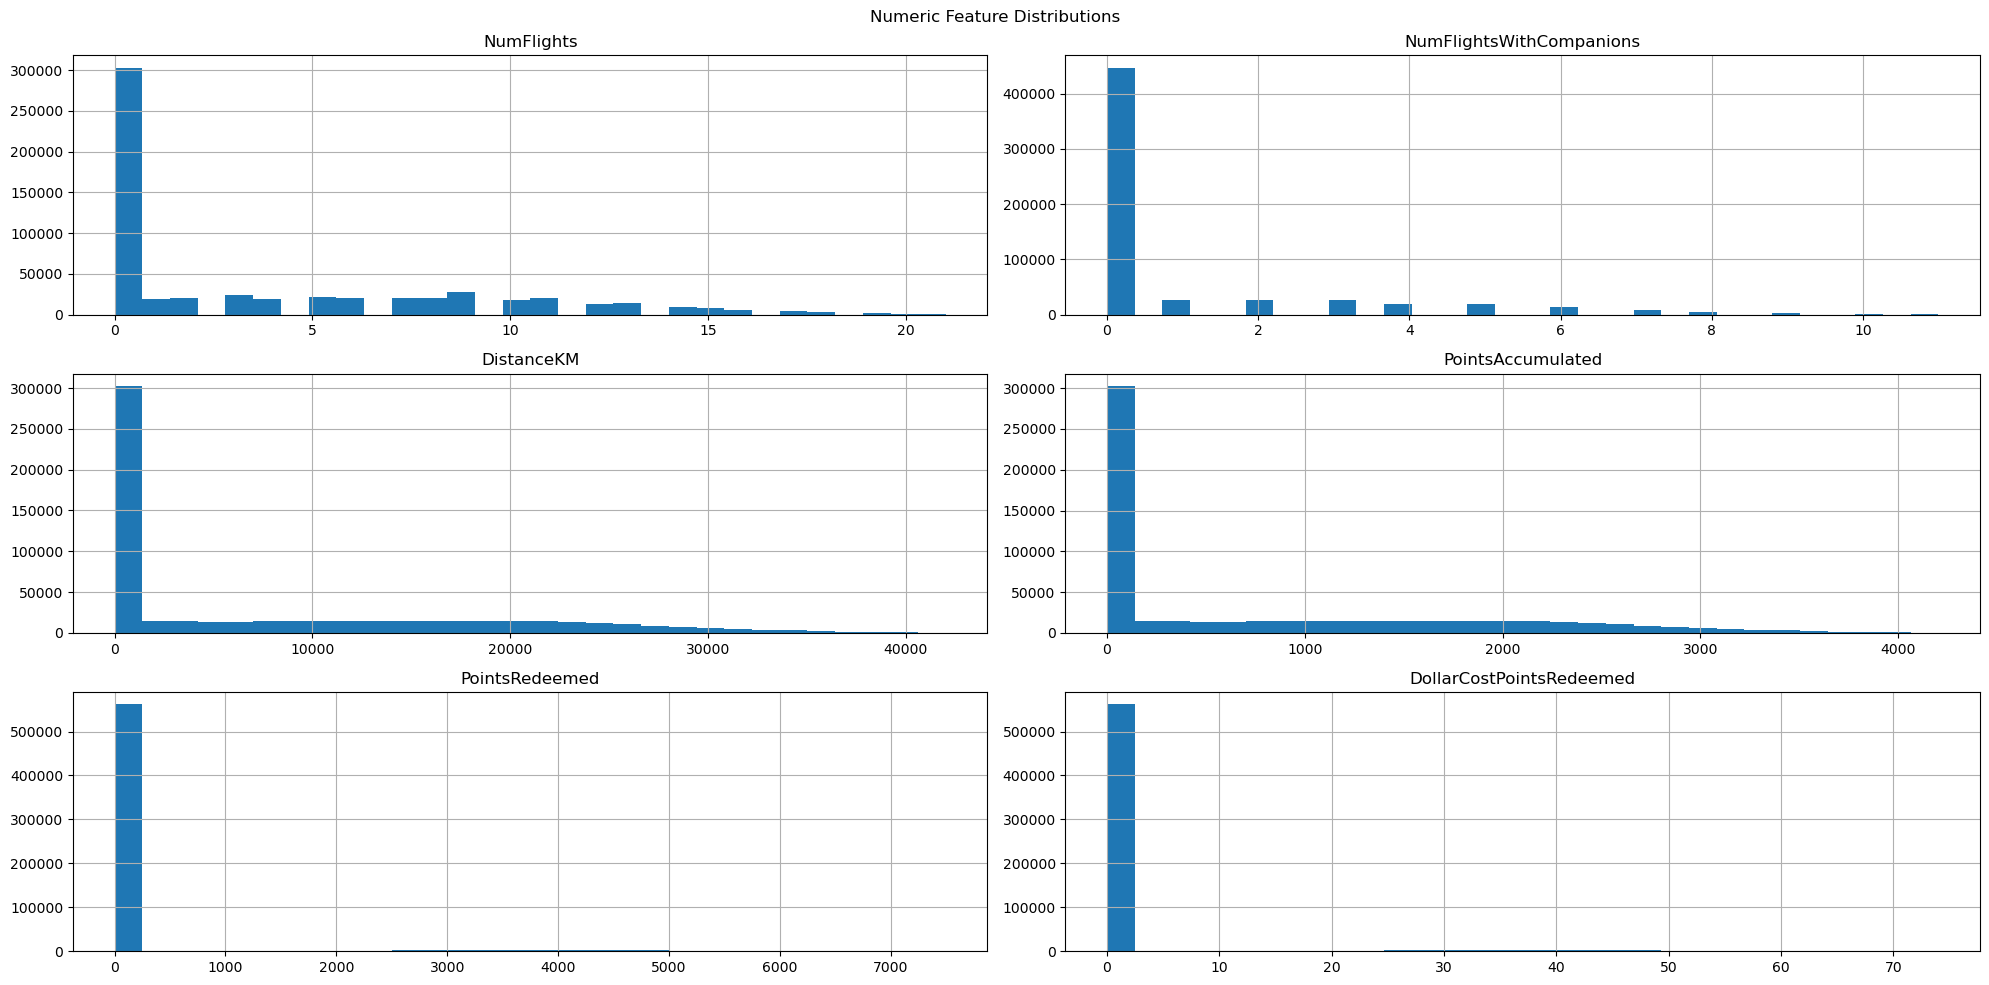

Número de outliers por variável:
NumFlights                   6814
NumFlightsWithCompanions    95880
DistanceKM                   1828
PointsAccumulated            1821
PointsRedeemed              34884
DollarCostPointsRedeemed    34884
dtype: int64


In [45]:
numeric_flights = ["NumFlights", "NumFlightsWithCompanions", "DistanceKM", "PointsAccumulated", "PointsRedeemed", "DollarCostPointsRedeemed"]

# Histograms
flight[numeric_flights].hist(bins=30, figsize=(20, 10))
plt.suptitle("Numeric Feature Distributions")
plt.tight_layout()
plt.show()

# Identificar outliers usando IQR
Q1 = flight[numeric_flights].quantile(0.25)
Q3 = flight[numeric_flights].quantile(0.75)
IQR = Q3 - Q1

outliers = ((flight[numeric_flights] < (Q1 - 1.5 * IQR)) | (flight[numeric_flights] > (Q3 + 1.5 * IQR))).sum()
print("Número de outliers por variável:")
print(outliers)

### 4.3 Multivariate analysis


In [46]:
flight.groupby(["Year", "Month"])["NumFlights"].sum()

Year  Month
2019  1         38645
      2         38753
      3         52952
      4         45638
      5         53729
      6         67803
      7         75705
      8         65973
      9         51971
      10        48921
      11        45897
      12        64287
2020  1         47266
      2         47102
      3         63398
      4         55080
      5         64345
      6         79345
      7         88023
      8         77554
      9         62370
      10        59427
      11        56036
      12        76462
2021  1         48422
      2         47841
      3         65889
      4         55915
      5         75675
      6         91401
      7        102553
      8         89049
      9         71788
      10        67916
      11        64310
      12        86954
Name: NumFlights, dtype: int64

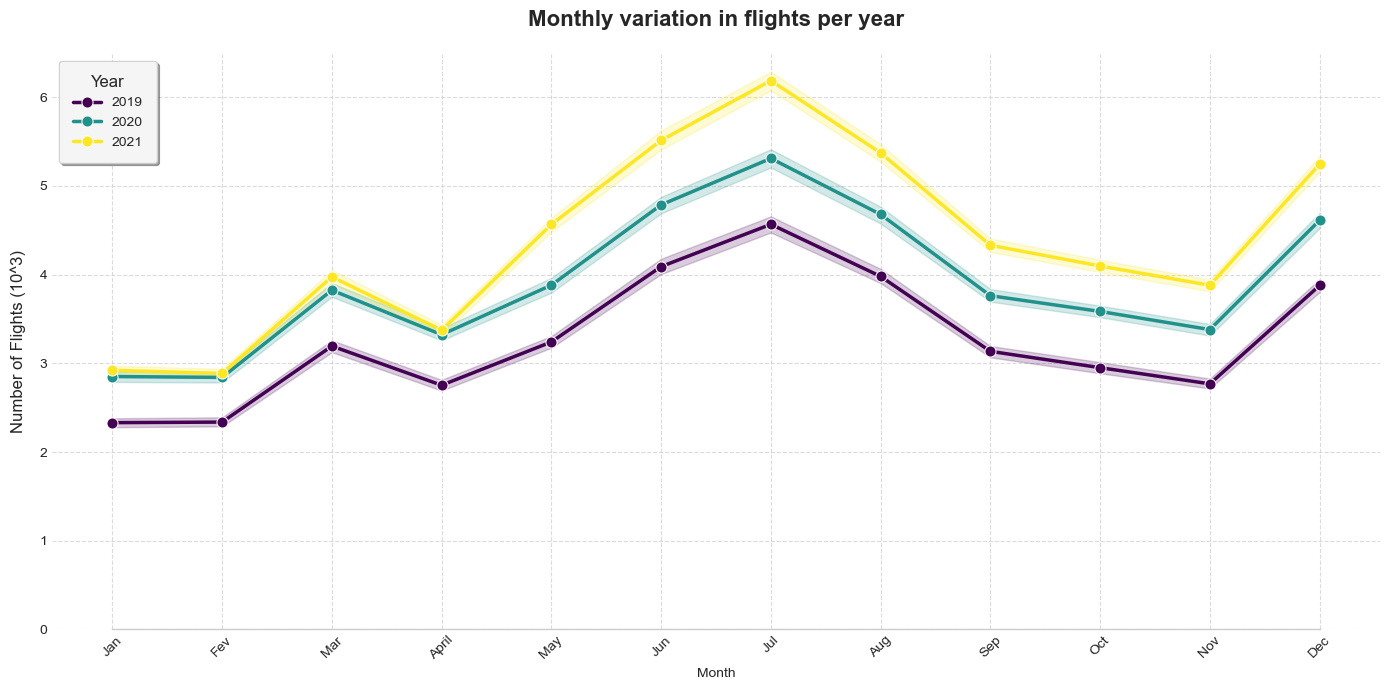

In [47]:
# Choosing the style 
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 7))

# Create the graph
ax = sns.lineplot(
        data=flight,
        x="Month",
        y="NumFlights",
        hue="Year",
        palette="viridis",  # Color scheme
        linewidth=2.5,
        marker='o',         # Add markers
        markersize=8     
    )

# Melhorando os títulos e rótulos
plt.title("Monthly variation in flights per year",
            fontsize=16,
            fontweight='bold',
            pad=20)
plt.ylabel('Number of Flights (10^3)', fontsize=12, labelpad=10)

# Create a legend
plt.legend(
        title='Year',
        title_fontsize=12,
        fontsize=10,
        frameon=True,
        fancybox=True,
        framealpha=0.9,
        shadow=True,
        borderpad=1
)

# Ajustando os eixos
plt.xticks(range(1, 13),
           ['Jan', 'Fev', 'Mar', 'April', 'May', 'Jun',
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
           rotation=45)
plt.ylim(0)

    # Adicionando grid
plt.grid(True, linestyle='--', alpha=0.7)

    # Ajustando as bordas
sns.despine(trim=True, left=True)

    # Ajustando o layout
plt.tight_layout()

    # Mostrando o gráfico
plt.show()

In [48]:
#sns.pairplot(data=flight, vars= numeric_flights)

#plt.show()

# meti # para nao demorar a correr

During the exploration, several features were found to have strong linear relationships. These are not coincidental correlations but rather indicators of specific business rules used by the airline.

A strong positive correlation was observed between DistanceKM and PointsAccumulated. This is expected, as it reflects the loyalty program's core mechanic: customers earn points based on the distance they fly.

However, the analysis revealed a more precise calculation. The data shows that the number of points awarded is based on a fixed ratio. For example, flights of 2,388 km and 2,380 km both yield 238 points. This strongly suggests that the business rule is PointsAccumulated = floor(DistanceKM / 10).

This means that points are awarded for every full 10 kilometers flown, and any remaining unit-level distance is truncated. Understanding this specific rule is key, as it explains the exact, predictable nature of how points are earned.

Similarly, the strong correlation between PointsRedeemed and DollarCostPointsRedeemed points to a derived relationship, not a behavioral one.

The DollarCostPointsRedeemed is likely an internal accounting metric. It is almost certainly calculated by multiplying the PointsRedeemed by a fixed monetary rate (a "cost-per-point") that the airline uses to track the financial liability of its loyalty program. This makes one variable a direct linear function of the other, explaining the perfect or near-perfect correlation.

The heatmap below comprove the things that we observed

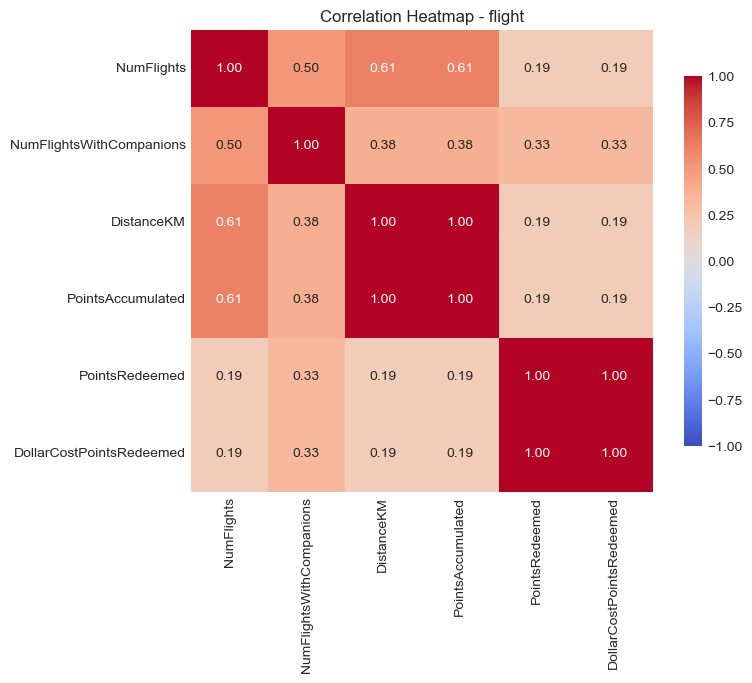

In [49]:

correlation_matrix = flight[numeric_flights].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, 
            annot=True,           # Mostrar valores dentro dos quadrados
            cmap='coolwarm',      # Esquema de cores (azul-vermelho)
            vmin=-1, vmax=1,      # Limites da escala de correlação
            center=0,             # Centralizar em 0
            square=True,          # Quadrados em vez de retângulos
            fmt='.2f',            # Formato com 2 casas decimais
            cbar_kws={'shrink': 0.8})  # Tamanho da barra de cores

plt.title("Correlation Heatmap - flight")
plt.show()
plt.show()

In [50]:
numeric_cols = [
    'NumFlights',
    'DistanceKM',
    'PointsAccumulated',
    'PointsRedeemed',
    'DollarCostPointsRedeemed',
    'Customer Lifetime Value',
    'Income'
]

merged = pd.merge(customer, flight, on='Loyalty#', how='inner')
agg = merged.groupby('Loyalty#', as_index=False).agg({
    'NumFlights': 'sum',
    'DistanceKM': 'sum',
    'PointsAccumulated': 'sum',
    'PointsRedeemed': 'sum',
    'DollarCostPointsRedeemed': 'sum',
    'Customer Lifetime Value': 'mean',
    'Income': 'first',
    'LoyaltyStatus': 'first',
    'Gender': 'first',
    'Education': 'first',
})

In [51]:
#n_rows = len(categorical_customer)
#n_cols = len(numeric_flights)

#fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))

#for i, cat in enumerate(categorical_customer):
    #for j, num in enumerate(numeric_flights):
        #ax = axes[i, j]
        #sns.boxplot(x=cat, y=num, data=merged, ax=ax)
        #ax.set_title(f'{num} by {cat}')
        #ax.set_xlabel('')
        #ax.set_ylabel('')
        #ax.tick_params(axis='x', rotation=45)

#plt.tight_layout()
#plt.show()

# meti # para nao demorar a correr

In [52]:
#sns.pairplot(merged[numeric_cols], diag_kind='kde', plot_kws={'alpha':0.6})
#plt.suptitle('Pairplot – Customer & Flight Numerical Variables', y=1.02)
#plt.show()

# so coloquei # para nao demorar a correr


## 5. Data Pre-processing

### 5.1 Feature Engineering

This section aggregates flight-related data for each customer based on their unique Loyalty# identifier.
A reusable function (cumulative_customer) is defined to compute the total sum of a selected column (e.g., number of flights, distance traveled, points accumulated, and points redeemed) per customer.
The resulting aggregated datasets are then merged into the main customer DataFrame to enrich it with cumulative statistics for each individual.

In [53]:
from scipy.stats import linregress


def cumulative_customer(col):
    total = flight.groupby("Loyalty#")[col].sum().reset_index()
    return total


def calculate_seasonality(df):
    df = df.copy()
    def get_season(month):
        if month in [12, 1, 2]: return 'Winter'
        elif month in [3, 4, 5]: return 'Spring'
        elif month in [6, 7, 8]: return 'Summer'
        else: return 'Fall'

    df['Season'] = df['Month'].apply(get_season)

    # 2. Calcular Ratios por Estação (Summer_Ratio, etc.)
    season_counts = df.pivot_table(index='Loyalty#', columns='Season', values='NumFlights', aggfunc='sum', fill_value=0)
    total = season_counts.sum(axis=1).replace(0, 1) # Evitar divisão por zero
    season_ratios = season_counts.div(total, axis=0).add_suffix('_Ratio').reset_index()

    # 3. Índice de Sazonalidade (Desvio Padrão dos meses)
    monthly = df.pivot_table(index='Loyalty#', columns='Month', values='NumFlights', aggfunc='sum', fill_value=0)
    # Se desvio padrão é alto, cliente é muito sazonal
    season_index = (monthly.std(axis=1) / (monthly.mean(axis=1) + 0.001)).reset_index(name='Seasonality_Index')

    # Juntar as duas partes de sazonalidade
    return season_ratios.merge(season_index, on='Loyalty#')

def calculate_trend(df):
    # Função auxiliar para calcular declive (slope)
    def get_slope(series):
        if len(series) < 2: return 0
        # Cria uma linha de tendência (y=mx+b) e devolve o m (slope)
        return linregress(np.arange(len(series)), series.values)[0]

    # Ordenar por tempo para a tendência fazer sentido
    df_sorted = df.sort_values(['Loyalty#', 'YearMonthDate'])

    # Calcular e devolver DataFrame
    # Nota: apply pode demorar um pouco se o dataset for gigante
    trends = df_sorted.groupby('Loyalty#')['NumFlights'].apply(get_slope).reset_index(name='Flight_Trend_Slope')
    return trends

In [54]:
total_flights = cumulative_customer("NumFlights")
total_DistanceKM = cumulative_customer("DistanceKM")
total_PointsRedeemed = cumulative_customer("PointsRedeemed")
total_PointsAccumulated = cumulative_customer("PointsAccumulated")
total_NumFlightsWithCompanions = cumulative_customer("NumFlightsWithCompanions")

# 2. Calcular as novas features complexas
seasonality_data = calculate_seasonality(flight)
trend_data = calculate_trend(flight)

In [55]:
new_columns = [
    total_flights,
    total_DistanceKM,
    total_PointsRedeemed,
    total_PointsAccumulated,
    total_NumFlightsWithCompanions,
    seasonality_data,
    trend_data
]


for data in new_columns:
    customer = customer.merge(data, on="Loyalty#", how="left")

customer = customer.fillna(0)

customer['Companion_Ratio'] = customer['NumFlightsWithCompanions'] / customer['NumFlights']
customer['Avg_Distance_Flight'] = customer['DistanceKM'] / customer['NumFlights']

# Tratar infinitos (caso divisão por zero)
customer = customer.replace([np.inf, -np.inf], 0)

# Substitui os novos NaNs (do 0/0) por 0
customer[['Companion_Ratio', 'Avg_Distance_Flight']] = customer[['Companion_Ratio', 'Avg_Distance_Flight']].fillna(0)

customer.head(3)

,Loyalty#,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,Postal code,...,PointsAccumulated,NumFlightsWithCompanions,Fall_Ratio,Spring_Ratio,Summer_Ratio,Winter_Ratio,Seasonality_Index,Flight_Trend_Slope,Companion_Ratio,Avg_Distance_Flight
0,480934,Cecilia,Householder,Cecilia Householder,Canada,Ontario,Toronto,43.653225,-79.383186,M2Z 4K1,...,50693,53,0.206522,0.250000,0.451087,0.092391,0.705845,0.074131,0.288043,2755.733152
1,549612,Dayle,Menez,Dayle Menez,Canada,Alberta,Edmonton,53.544388,-113.490930,T3G 6Y6,...,42669,30,0.207273,0.301818,0.301818,0.189091,0.492776,0.000644,0.109091,1552.099636
2,429460,Necole,Hannon,Necole Hannon,Canada,British Columbia,Vancouver,49.282730,-123.120740,V6E 3D9,...,23827,37,0.258621,0.318966,0.172414,0.250000,0.950412,-0.159588,0.318966,2054.966379


In [56]:
customer["Province or State"].unique()

array(['Ontario', 'Alberta', 'British Columbia', 'Quebec',
       'New Brunswick', 'Manitoba', 'Nova Scotia', 'Saskatchewan',
       'Newfoundland', 'Yukon', 'Prince Edward Island'], dtype=object)

In [57]:
last_flight = (
    flight[flight['NumFlights'] > 0]
    .groupby('Loyalty#')['YearMonthDate']
    .max()
    .reset_index()
    .rename(columns={'YearMonthDate': 'last_flight_date'})
)
reference_date = flight['YearMonthDate'].max()

last_flight['recency_months'] = (
        (reference_date.year - last_flight['last_flight_date'].dt.year) * 12 +
        (reference_date.month - last_flight['last_flight_date'].dt.month)
)
customer = customer.merge(last_flight[['Loyalty#', 'recency_months']], on='Loyalty#', how='left')
customer.replace({"recency_months": {np.nan: -1}}, inplace=True)
customer['recency_months'] = customer['recency_months'].astype(int)
customer.head(3)


,Loyalty#,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,Postal code,...,NumFlightsWithCompanions,Fall_Ratio,Spring_Ratio,Summer_Ratio,Winter_Ratio,Seasonality_Index,Flight_Trend_Slope,Companion_Ratio,Avg_Distance_Flight,recency_months
0,480934,Cecilia,Householder,Cecilia Householder,Canada,Ontario,Toronto,43.653225,-79.383186,M2Z 4K1,...,53,0.206522,0.250000,0.451087,0.092391,0.705845,0.074131,0.288043,2755.733152,0
1,549612,Dayle,Menez,Dayle Menez,Canada,Alberta,Edmonton,53.544388,-113.490930,T3G 6Y6,...,30,0.207273,0.301818,0.301818,0.189091,0.492776,0.000644,0.109091,1552.099636,0
2,429460,Necole,Hannon,Necole Hannon,Canada,British Columbia,Vancouver,49.282730,-123.120740,V6E 3D9,...,37,0.258621,0.318966,0.172414,0.250000,0.950412,-0.159588,0.318966,2054.966379,11


In [58]:
customer[(customer["NumFlights"] == 0) & (customer["CancellationDate"] == pd.Timestamp("1904-01-01")) ].head(3)
#Clients that are active but never flew

,Loyalty#,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,Postal code,...,NumFlightsWithCompanions,Fall_Ratio,Spring_Ratio,Summer_Ratio,Winter_Ratio,Seasonality_Index,Flight_Trend_Slope,Companion_Ratio,Avg_Distance_Flight,recency_months
66,329382,Ngoc,Dubuisson,Ngoc Dubuisson,Canada,Quebec,Montreal,45.501690,-73.567253,H2T 9K8,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
149,695755,Horace,Astolfi,Horace Astolfi,Canada,British Columbia,West Vancouver,49.328625,-123.160190,V6V 8Z3,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
156,203809,Stefani,Hiney,Stefani Hiney,Canada,Alberta,Edmonton,53.544388,-113.490930,T3G 6Y6,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1


In [59]:
customer["Tenure"] = (pd.Timestamp.today() - customer["EnrollmentDateOpening"]).dt.days
customer.sort_values(by='Tenure', ascending=True, inplace=True)

PointsUtilizationRate:
A proporção de pontos que o cliente efetivamente usou em relação ao total que acumulou.
- Alto valor (próximo de 1): cliente que usa os pontos com frequência, pode indicar um cliente engajado e atento às recompensas.
- Baixo valor (próximo de 0): cliente que acumula mas não resgata, pode indicar desinteresse, esquecimento ou falta de oportunidades relevantes de resgate.


In [60]:
customer[(customer["NumFlights"] == 0) & (customer["Customer Lifetime Value"] > 0)].head(3)

,Loyalty#,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,Postal code,...,Fall_Ratio,Spring_Ratio,Summer_Ratio,Winter_Ratio,Seasonality_Index,Flight_Trend_Slope,Companion_Ratio,Avg_Distance_Flight,recency_months,Tenure
9494,170982,Elin,Standard,Elin Standard,Canada,Quebec,Montreal,45.501690,-73.567253,H2Y 4R4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,1451
10877,253412,Glayds,Nesspor,Glayds Nesspor,Canada,Quebec,Quebec City,46.813877,-71.207977,G1B 3L5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,1451
427,123928,Dimple,Stallworth,Dimple Stallworth,Canada,Quebec,Tremblant,46.118462,-74.596184,H5Y 2S9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,1451


In [61]:
customer["PointsUtilizationRate"] = customer["PointsRedeemed"] / (customer["PointsAccumulated"] + 1)

In [62]:
scaler = MinMaxScaler()

cols_to_combine = ['NumFlights', 'Income', 'Tenure']

df_temp_calc = pd.DataFrame(scaler.fit_transform(customer[cols_to_combine]), 
                            columns=cols_to_combine, 
                            index=customer.index)

# nova fórmula de CLV com pesos ajustados
customer['CLV'] = (
    (df_temp_calc['NumFlights'] * 0.50) + 
    (df_temp_calc['Income'] * 0.30) + 
    (df_temp_calc['Tenure'] * 0.20)
)

#### 5.1.1 Feature Engineering Exploration

NOTE: 
 The map is interactive. Hover over the data points to view detailed information

In [63]:
import plotly.express as px


# Group by Province/State and count the number of customers
customermap = customer.groupby("Province or State").agg({
    "Loyalty#": "count",  # Count number of customers
    "Latitude": "first",
    "Longitude": "first",
    "LoyaltyStatus": lambda x: x.mode()[0],
    "NumFlights": "mean",
    "DistanceKM": "mean",
}).reset_index().rename(columns={"Loyalty#": "NumCustomers"})

# Create the map
fig = px.scatter_mapbox(
    customermap,
    lat="Latitude",
    lon="Longitude",
    size="NumCustomers",
    color="NumCustomers",
    hover_name="Province or State",
    hover_data={"NumCustomers": True, "Latitude": False, "Longitude": False, "NumFlights": True, "DistanceKM" : True, "LoyaltyStatus": True},
    zoom=3,
    height=700,
    title="Number of Customers by Canadian Province/State",
    color_continuous_scale=px.colors.sequential.Viridis
)

# Update layout for better visualization
fig.update_layout(
    mapbox_style="carto-positron",
    margin={"r": 0, "t": 50, "l": 0, "b": 0},
    coloraxis_colorbar=dict(
        title="Number of Customers",
        thicknessmode="pixels",
        thickness=20,
        lenmode="pixels",
        len=300,
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.01
    )
)

fig.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_31420\2146920867.py:15: DeprecationWarning: *scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/
  fig = px.scatter_mapbox(


### 5.2 Feature Encoding

In [64]:
customer.columns

Index(['Loyalty#', 'First Name', 'Last Name', 'Customer Name', 'Country',
       'Province or State', 'City', 'Latitude', 'Longitude', 'Postal code',
       'Gender', 'Education', 'Location Code', 'Income', 'Marital Status',
       'LoyaltyStatus', 'EnrollmentDateOpening', 'CancellationDate',
       'Customer Lifetime Value', 'EnrollmentType', 'NumFlights', 'DistanceKM',
       'PointsRedeemed', 'PointsAccumulated', 'NumFlightsWithCompanions',
       'Fall_Ratio', 'Spring_Ratio', 'Summer_Ratio', 'Winter_Ratio',
       'Seasonality_Index', 'Flight_Trend_Slope', 'Companion_Ratio',
       'Avg_Distance_Flight', 'recency_months', 'Tenure',
       'PointsUtilizationRate', 'CLV'],
      dtype='object')

In [65]:
metric_features = [
    "Income",
    "CLV",
    "NumFlights",
    "DistanceKM",
    "PointsRedeemed",
    "PointsAccumulated",
    "NumFlightsWithCompanions",

    "Fall_Ratio",
    "Spring_Ratio",
    "Summer_Ratio",
    "Winter_Ratio",
    "Seasonality_Index",

    "Flight_Trend_Slope",
    "Companion_Ratio",
    "Avg_Distance_Flight",

    "recency_months",
    "Tenure",
    "PointsUtilizationRate"
]

categorical_features = [
    'Gender',
    'Education',
    'Marital Status',
    'EnrollmentType',
    'Province or State',
    'City'
]

In [66]:
customer_oh = pd.get_dummies(customer[categorical_features], prefix='oh', drop_first=True, dtype=int)
customer = pd.concat([customer, customer_oh], axis=1)
non_metric_features = customer.columns[customer.columns.str.startswith('oh_')].tolist()

In [67]:
features_to_use = metric_features + non_metric_features

unused_features = [col for col in customer.columns if col not in features_to_use]

print(f"Features Métricas ({len(metric_features)}): {metric_features}")
print(f"Features One-Hot ({len(non_metric_features)}): {non_metric_features}")
print(f"Features Unused/Descartadas ({len(unused_features)}): {unused_features}")

Features Métricas (18): ['Income', 'CLV', 'NumFlights', 'DistanceKM', 'PointsRedeemed', 'PointsAccumulated', 'NumFlightsWithCompanions', 'Fall_Ratio', 'Spring_Ratio', 'Summer_Ratio', 'Winter_Ratio', 'Seasonality_Index', 'Flight_Trend_Slope', 'Companion_Ratio', 'Avg_Distance_Flight', 'recency_months', 'Tenure', 'PointsUtilizationRate']
Features One-Hot (46): ['oh_male', 'oh_College', 'oh_Doctor', 'oh_High School or Below', 'oh_Master', 'oh_Married', 'oh_Single', 'oh_Standard', 'oh_British Columbia', 'oh_Manitoba', 'oh_New Brunswick', 'oh_Newfoundland', 'oh_Nova Scotia', 'oh_Ontario', 'oh_Prince Edward Island', 'oh_Quebec', 'oh_Saskatchewan', 'oh_Yukon', 'oh_Calgary', 'oh_Charlottetown', 'oh_Dawson Creek', 'oh_Edmonton', 'oh_Fredericton', 'oh_Halifax', 'oh_Hull', 'oh_Kelowna', 'oh_Kingston', 'oh_London', 'oh_Moncton', 'oh_Montreal', 'oh_Ottawa', 'oh_Peace River', 'oh_Quebec City', 'oh_Regina', "oh_St. John's", 'oh_Sudbury', 'oh_Thunder Bay', 'oh_Toronto', 'oh_Tremblant', 'oh_Trenton', 'o

In [68]:
customer = customer[metric_features + non_metric_features].copy()

### 5.3 Feature Selection

In [69]:
columns_to_drop = [
    # --- Identificadores & PII ---
    'Loyalty#', 'First Name', 'Last Name', 'Customer Name',
    'Country', 'Postal code', 'Latitude', 'Longitude',

    # --- Originais categóricas (já codificadas) ---
    'Gender',
    'Education',
    'Marital Status',
    'EnrollmentType',
    'Province or State',
    'City',
    'Location Code',
    'LoyaltyStatus',

    # --- Datas ---
    'EnrollmentDateOpening',
    'CancellationDate',

    # --- Redundâncias ---
    'Customer Lifetime Value',
    'DistanceKM',
    'PointsRedeemed',
    'PointsAccumulated',
    'NumFlightsWithCompanions'
]

customer = customer.drop(columns=columns_to_drop, errors='ignore')
customer.head(3)

fs_metric_features = [f for f in metric_features if f in customer.columns]

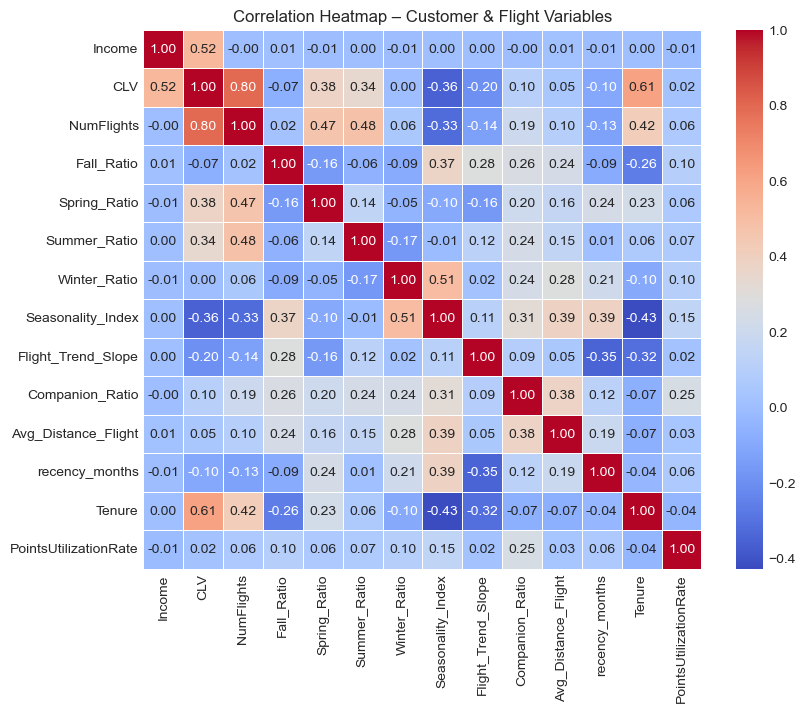

In [70]:
plt.figure(figsize=(9,7))
corr = customer[fs_metric_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap – Customer & Flight Variables')
plt.show()

### 5.4 Feature Scalling

#### 5.4.1 MinMaxScaler

In [71]:
df_minmax = customer.copy()

In [72]:
mm_scaler = MinMaxScaler()
mm_scaled_feat = mm_scaler.fit_transform(df_minmax[fs_metric_features])

df_minmax[fs_metric_features] = mm_scaled_feat
df_minmax[fs_metric_features].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Income,16574.0,0.38,0.30,0.0,0.00,0.34,0.62,1.0
CLV,16574.0,0.45,0.19,0.0,0.31,0.46,0.58,1.0
NumFlights,16574.0,0.40,0.23,0.0,0.20,0.46,0.58,1.0
Fall_Ratio,16574.0,0.23,0.17,0.0,0.13,0.22,0.30,1.0
Spring_Ratio,16574.0,0.20,0.14,0.0,0.10,0.20,0.28,1.0
Summer_Ratio,16574.0,0.28,0.17,0.0,0.18,0.30,0.39,1.0
Winter_Ratio,16574.0,0.21,0.16,0.0,0.12,0.20,0.28,1.0
Seasonality_Index,16574.0,0.26,0.18,0.0,0.18,0.23,0.29,1.0
Flight_Trend_Slope,16574.0,0.51,0.14,0.0,0.43,0.50,0.60,1.0
Companion_Ratio,16574.0,0.23,0.13,0.0,0.16,0.23,0.30,1.0


MinMaxScaler compresses all data points into a fixed range between 0 and 1, where the lowest value becomes 0 and the highest becomes 1, ensuring that no single variable dominates the model simply because it has larger raw numbers.

#### 5.4.2 StandardScaler

In [73]:
df_standard = customer.copy()

In [74]:
scaler = StandardScaler()
ss_scaled_feat = scaler.fit_transform(customer[fs_metric_features])

df_standard[fs_metric_features] = ss_scaled_feat
df_standard[fs_metric_features].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Income,16574.0,-0.0,1.0,-1.24,-1.24,-0.12,0.81,2.05
CLV,16574.0,-0.0,1.0,-2.35,-0.72,0.07,0.74,2.93
NumFlights,16574.0,0.0,1.0,-1.76,-0.87,0.26,0.77,2.59
Fall_Ratio,16574.0,-0.0,1.0,-1.36,-0.56,-0.06,0.41,4.59
Spring_Ratio,16574.0,-0.0,1.0,-1.42,-0.72,0.07,0.63,5.84
Summer_Ratio,16574.0,0.0,1.0,-1.66,-0.58,0.12,0.66,4.35
Winter_Ratio,16574.0,-0.0,1.0,-1.28,-0.56,-0.07,0.39,4.79
Seasonality_Index,16574.0,0.0,1.0,-1.47,-0.44,-0.19,0.18,4.13
Flight_Trend_Slope,16574.0,0.0,1.0,-3.71,-0.55,-0.06,0.66,3.58
Companion_Ratio,16574.0,-0.0,1.0,-1.70,-0.54,0.01,0.54,5.73


StandardScaler transforms the data so that the mean is 0 and the standard deviation is 1. It tells us how many standard deviations a data point is above or below the average, without imposing fixed maximum or minimum limits.

#### 5.4.3 Comparing different scalers vs original data

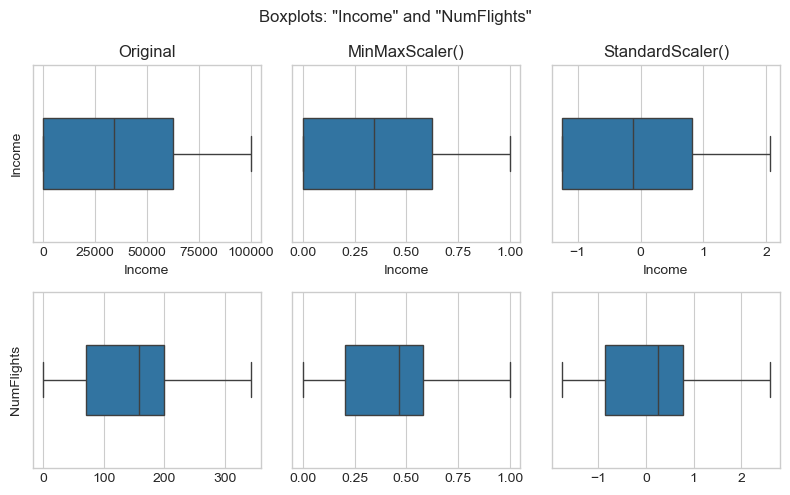

In [75]:

sns.set_style('whitegrid')
# Aumentar o figsize para que 6 boxplots fiquem legíveis
fig, axes = plt.subplots(2, 3, figsize=(8, 5), tight_layout=True, sharey='row')

bp_feat_l = 'Income'

sns.boxplot(customer, x=bp_feat_l, ax=axes[0][0], width=.4)
axes[0][0].set_title('Original')
axes[0][0].set_ylabel(bp_feat_l)

sns.boxplot(df_minmax, x=bp_feat_l, ax=axes[0][1], width=.4)
axes[0][1].set_title('MinMaxScaler()')

sns.boxplot(df_standard, x=bp_feat_l, ax=axes[0][2], width=.4)
axes[0][2].set_title('StandardScaler()')



bp_feat_r = 'NumFlights'

sns.boxplot(customer, x=bp_feat_r, ax=axes[1][0], width=.4)
axes[1][0].set_ylabel(bp_feat_r)

sns.boxplot(df_minmax, x=bp_feat_r, ax=axes[1][1], width=.4)

sns.boxplot(df_standard, x=bp_feat_r, ax=axes[1][2], width=.4)


axes[1][0].set_xlabel(None)
axes[1][1].set_xlabel(None)
axes[1][2].set_xlabel(None)

fig.suptitle('Boxplots: "{}" and "{}"'.format(bp_feat_l, bp_feat_r))
plt.show()

Text(0.5, 0.98, 'Boxplots: "Income"')

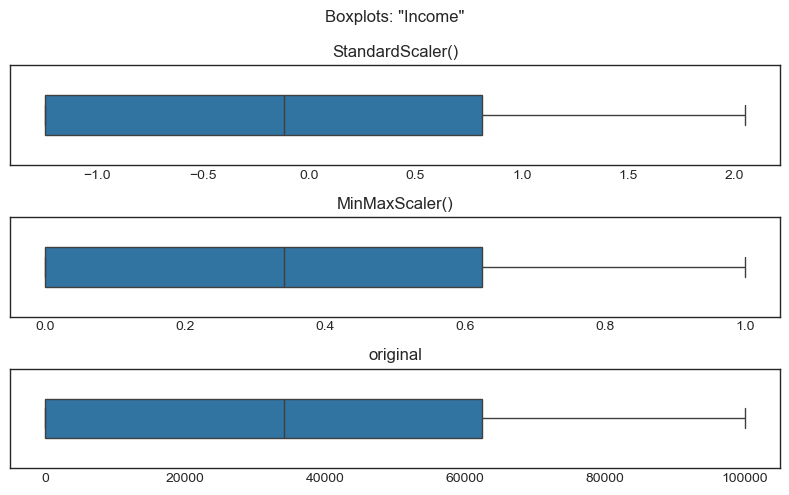

In [76]:
sns.set_style('white')

fig, axes = plt.subplots(3,1, figsize=(8,5), tight_layout=True,)

sns.boxplot(customer, x=bp_feat_l, ax=axes[2], width=.4)
sns.boxplot(df_minmax, x=bp_feat_l, ax=axes[1], width=.4)
sns.boxplot(df_standard, x=bp_feat_l, ax=axes[0], width=.4)

axes[0].set_title("StandardScaler()")
axes[0].set_xlabel(None)
axes[1].set_title("MinMaxScaler()")
axes[1].set_xlabel(None)
axes[2].set_title("original")
axes[2].set_xlabel(None)

plt.suptitle('Boxplots: "{}"'.format(bp_feat_l))

As we can see through the boxplots, MinMaxScaler forces the data into the 0-1 interval destroying the subtle differences in variance among average customers. This compression leads to clustering results that are less discriminatory.

StandardScaler preserves the relative distances between data points. This makes it ideal for the distance-based algorithms that we will use later, as it ensures that distances are calculated fairly and robustly across all features.

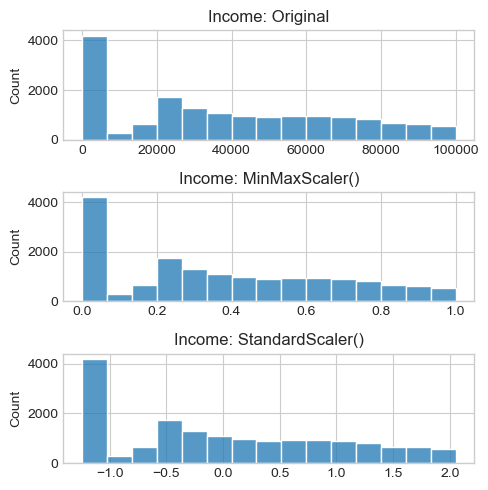

In [77]:
sns.set_style('whitegrid')

# Create subplots with 3 rows, 1 column:
fig, axes = plt.subplots(3,1, 
                         figsize=(5,5), tight_layout=True)

# Which feature do you want to visualize?
hp_feat = 'Income'

# common function args for histplot
hp_args = dict(x=hp_feat, bins=15)


sns.histplot(customer, ax=axes[0], **hp_args)
axes[0].set_title('{}: Original'.format(hp_feat))
axes[0].set_xlabel(None)

sns.histplot(df_minmax, ax=axes[1], **hp_args)
axes[1].set_title('{}: MinMaxScaler()'.format(hp_feat))
axes[1].set_xlabel(None)

sns.histplot(df_standard, ax=axes[2], **hp_args)
axes[2].set_title('{}: StandardScaler()'.format(hp_feat))
axes[2].set_xlabel(None)


plt.show()

sns.set()

We decided to keep the StandardScaler because it best preserved relative distances across features and provided the most suitable scaling for our clustering objectives.

In [78]:
customer = df_standard.copy()

In [79]:
sns.set()

### 5.5 Outliers removal (DBSCAN)

We create a clean dataset using DBSCAN for K-Means training, ensuring that centroids are not distorted by extreme values. However, these outliers are saved in df_outliers for separate analysis, as they can also represent valuable customers.

In [80]:
len(fs_metric_features)

14

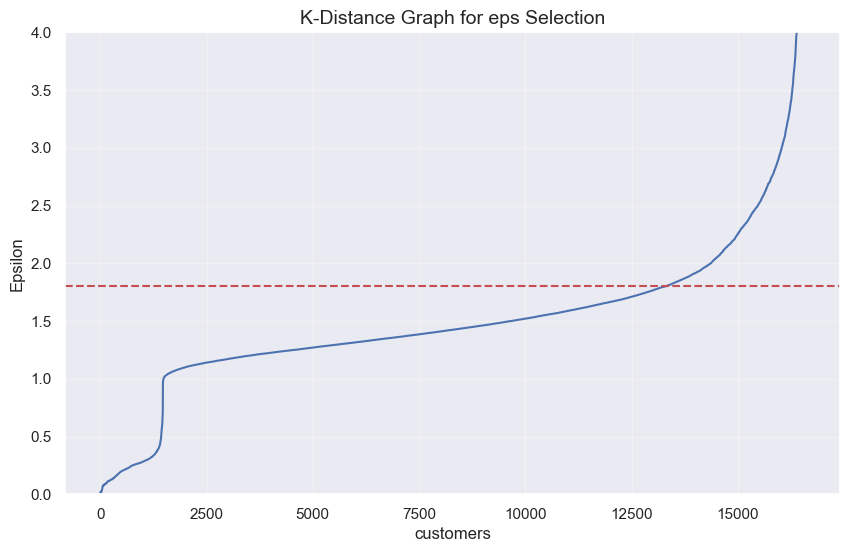

In [81]:
neigh = NearestNeighbors(n_neighbors=28) #2* nr de features
neigh.fit(customer[fs_metric_features])
distances, _ = neigh.kneighbors(customer[fs_metric_features])

# Ordenar e plotar
distances = np.sort(distances[:, -1], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-Distance Graph for eps Selection', fontsize=14)
plt.xlabel('customers')
plt.ylabel('Epsilon')
plt.grid(True, alpha=0.3)
plt.axhline(y=1.8, color='r', linestyle='--', label='Potential eps (elbow)')
plt.ylim(0,4)
plt.show()

In [82]:
all_customers = customer.copy()

In [83]:
dbscan = DBSCAN(eps=1.8, min_samples=28, n_jobs=-1) # eps was later found using the K-Distance Graph for eps Selection
dbscan_labels = dbscan.fit_predict(customer[fs_metric_features]) # ou features_modelo

outlier_count = Counter(dbscan_labels)
print(f"DBSCAN results: {outlier_count}")
print(f"Outliers detected (-1): {outlier_count[-1]}")
n_core = sum([count for label, count in outlier_count.items() if label != -1])
print(f"Core customers: {n_core}")

customer_out = customer[dbscan_labels == -1].copy()

# data frame limpo scaled para o kmeans
customer = customer[dbscan_labels != -1].copy()

print(f"\nWorking with {len(customer):,} core customers, {np.round(customer.shape[0] / all_customers.shape[0], 4)}")
print(f"Outliers saved for later: {len(customer_out)}")

DBSCAN results: Counter({np.int64(1): 13516, np.int64(-1): 1585, np.int64(0): 1473})
Outliers detected (-1): 1585
Core customers: 14989

Working with 14,989 core customers, 0.9044
Outliers saved for later: 1585


## 6. Data Segmentation

### 6.1 RFM Analysis

alterar M depois do feature engineering

To better understand customer behavior and identify meaningful subgroups, we applied an RFM (recency, frequency, monetary) segmentation model. This method classifies customers based on:
- Recency (R): how recently they flew;
- Frequency (F): how often they fly;
- Monetary (M): how much money they spend.

This allows us to highlight high-value customers, at-risk customers, and behavioral patterns relevant for targeted marketing strategies.

atencao: alterar depois monetary (atualmente é CLV, mas temos de mudar)

In [84]:
def create_rfm_quantiles(df, recency, frequency, monetary, rec_ascending=True, freq_ascending=False, mon_ascending=False):
    rfm_df = df.copy()

    rfm_df["R_quintile"] = pd.qcut(rfm_df[recency].rank(method="first", ascending = rec_ascending),
                                   q=5, labels=[1,2,3,4,5]
                                   ).astype(int)
    rfm_df["F_quintile"] = pd.qcut(rfm_df[frequency].rank(method="first", ascending = freq_ascending),
                                   q=5, labels=[1,2,3,4,5]
                                   ).astype(int)
    rfm_df["M_quintile"] = pd.qcut(rfm_df[monetary].rank(method="first", ascending = mon_ascending),
                                   q=5, labels=[1,2,3,4,5]
                                   ).astype(int)

    rfm_df["RFM_score"] = (rfm_df["R_quintile"].astype(str) + rfm_df["F_quintile"].astype(str) + rfm_df["M_quintile"].astype(str))

    return rfm_df


In [85]:
customer = create_rfm_quantiles(customer,recency="recency_months",frequency="NumFlights", monetary="CLV", rec_ascending=False, freq_ascending=True, mon_ascending=True)
customer.head()
customer.iloc[:,17:]

,oh_High School or Below,oh_Master,oh_Married,oh_Single,oh_Standard,oh_British Columbia,oh_Manitoba,oh_New Brunswick,oh_Newfoundland,oh_Nova Scotia,...,oh_Vancouver,oh_Victoria,oh_West Vancouver,oh_Whistler,oh_Whitehorse,oh_Winnipeg,R_quintile,F_quintile,M_quintile,RFM_score
9494,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,5,1,1,511
10877,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,5,1,1,511
427,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,5,1,1,511
7985,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,5,1,1,511
11944,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,2,3,123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7976,0,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,5,4,3,543
13107,0,0,0,0,1,1,0,0,0,0,...,1,0,0,0,0,0,5,3,4,534
6173,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,5,3,5,535
11788,0,0,1,0,1,1,0,0,0,0,...,1,0,0,0,0,0,5,3,5,535


Customer segmentation

We defined a set of business-driven RFM rules to map each customer into a meaningful segment.  
This includes groups such as:

| Segment                |  RFM  | Description                                                                 |  Marketing                                              |
|------------------------|-------------------|-----------------------------------------------------------------------------|-----------------------------------------------------------------------------|
| **High-value Loyal customers**          | 555               | Recently active, purchase frequently, and spend the most.                   | VIP programs, exclusive rewards, early access to new products.             |
| **Loyal Frequent customers**    | X5X               | High purchase frequency, even if not always recent.                         | Personalized offers, loyalty nurturing, regular engagement.                |
| **Big spenders**       | XX5               | Highest monetary contribution but not necessarily frequent or recent.       | Promote premium products, upselling opportunities.                         |
| **Potential Loyalists**| 515 / 525         | Recent high spenders with still low frequency.                               | Encourage repeat purchases with progressive discounts or subscriptions.    |
| **New customers**      | 511 / 512         | Recently acquired but with low spending and low frequency.                  | Welcome campaigns, onboarding flows, recurring purchase incentives.        |
| **At Risk customers**  | 155 / 255         | Previously high frequency and/or high spenders, but not recent.             | Re-engagement campaigns, special comeback offers.                          |
| **Lost customers**     | 155  | High-value customers who have been inactive for a long time.                | Aggressive recovery campaigns, personalized incentives.                    |
| **Lost Cheap customers** | 111             | Long inactive, low frequency, and low spending.                             | Avoid spending resources trying to reacquire.                              |
| **Others**             | Mixed             | Customers who don’t fit cleanly into the above priority groups.             | General marketing strategies depending on overall business goals.          |


In [86]:
def assign_segment(rfm):
        r, f, m = int(rfm[0]), int(rfm[1]), int(rfm[2])

        if r == 5 and f == 5 and m == 5:
            return "High-value Loyal customers"

        if f == 5 and not (r == 5 and m == 5):  
            return "Loyal Frequent customers"

        if m == 5 and not (r == 5 and f == 5):
            return "Big spenders"

        if r == 5 and m == 5 and f in [1, 2]:
            return "Potential Loyalists"

        if r == 5 and f == 1 and m in [1,2]:
            return "New customers"

        if (r in [1,2]) and f == 5 and m == 5:
            return "At Risk customers"

        if r == 1 and f == 5 and m == 5:
            return "Lost customers"

        if r == 1 and f == 1 and m == 1:
            return "Lost Cheap customers"

        return "Others"


RFM_segment
Others                        8731
Loyal Frequent customers      2669
Big spenders                  1559
New customers                 1384
High-value Loyal customers     329
Lost Cheap customers           317
Name: count, dtype: int64

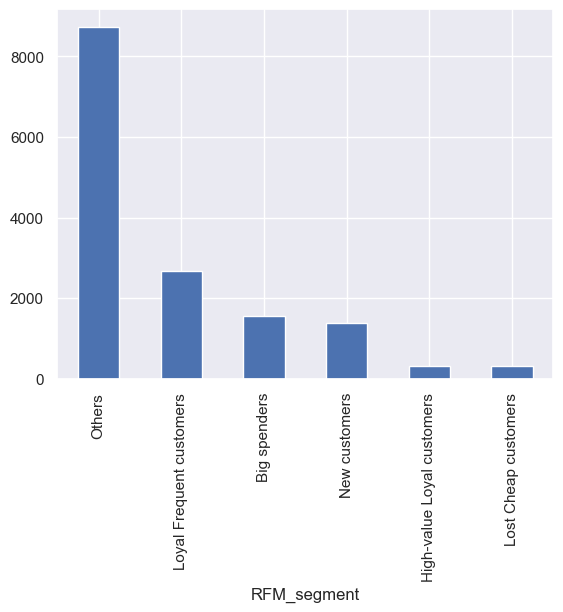

In [87]:
customer["RFM_segment"] = customer["RFM_score"].apply(assign_segment)
customer["RFM_segment"].value_counts().plot(kind="bar")
customer["RFM_segment"].value_counts()

The final distribution of segments highlights the behavioral diversity within the customer base.  
A larger presence of groups such as Loyal customers or Big spenders indicates strong retention and high engagement.  
Conversely, the proportion of At Risk or Lost customers reveals potential churn issues that may require dedicated retention strategies.

## 7. Data Clustering

In [88]:
fs_metric_features

['Income',
 'CLV',
 'NumFlights',
 'Fall_Ratio',
 'Spring_Ratio',
 'Summer_Ratio',
 'Winter_Ratio',
 'Seasonality_Index',
 'Flight_Trend_Slope',
 'Companion_Ratio',
 'Avg_Distance_Flight',
 'recency_months',
 'Tenure',
 'PointsUtilizationRate']

**Perspectives**

In [89]:
clustering_perspectives = {
    # Value-based segmentation: quem gera mais valor económico?
    "Value_Segmentation": [
        'CLV',
        'Income',
        'PointsUtilizationRate',
        'Tenure'
    ],

    # Behavioral segmentation: como os clientes se comportam nas viagens e no programa?
    "Behavioral_Segmentation": [
        'NumFlights',
        'Avg_Distance_Flight',
        'recency_months',
        'Companion_Ratio',
        'Flight_Trend_Slope',
        'Fall_Ratio',
        'Spring_Ratio',
        'Summer_Ratio',
        'Winter_Ratio',
        'Seasonality_Index'
    ],
}

In [90]:
# Demographic segmentation: quem são os clientes em termos de perfil socioeconómico?
Demographic_Segmentation = [
        'Province or State',
        'City',
        'Location Code',
        'Gender',
        'Education',
        'Marital Status'
]

### 7.1 Value segmentation perspective

#### 7.1.1 K-means with Hierarchical clustering

To ensure a robust segmentation, we will not rely solely on K-Means. 
We will compare it against Hierarchical Clustering to validate the number of clusters k and check if the customer groups have irregular shapes. The algorithm that best explains the variance R^2 of the data will be selected for the final profiling.

In [91]:
%load_ext autoreload
%autoreload 2

In [92]:
features_val = clustering_perspectives['Value_Segmentation']
df_value_kmeans_hc = customer[features_val].copy()
df_value_kmeans_hc

,CLV,Income,PointsUtilizationRate,Tenure
9494,-2.111388,-0.779707,-0.592971,-1.641869
10877,-0.982344,1.383990,-0.592971,-1.641869
427,-1.867423,-0.312172,-0.592971,-1.641869
7985,-2.353291,-1.243288,-0.592971,-1.641869
11944,0.045160,1.192490,-0.132972,-1.641869
...,...,...,...,...
7976,0.303178,-1.243288,-0.217197,1.785661
13107,0.697483,-0.440520,-0.074309,1.787053
6173,1.177678,0.478834,-0.196083,1.788445
11788,1.485031,1.099852,-0.123669,1.788445


In [93]:
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

In [94]:
hierarchical = AgglomerativeClustering(
    metric='euclidean'
)

In [95]:
df_value_sample = df_value_kmeans_hc.sample(n=5000, random_state=42)

We used a subset of the data to determine the optimal number of clusters k and the best clustering approach, overcoming the constraints about calculating the distance matrix for the entire population.

In [96]:
r2_scores = {}

r2_scores['kmeans'] = func.get_r2_scores(df_value_sample, df_value_kmeans_hc.columns.tolist(), kmeans)

for linkage in ['complete', 'average', 'single', 'ward']: # 4 different versions of HC
    r2_scores[linkage] = func.get_r2_scores(
        df_value_sample,                 # data
        df_value_kmeans_hc.columns.tolist(),   # features of perspective
        # use HClust, changing the linkage at each iteration
        hierarchical.set_params(linkage=linkage) 
    )

c:\Users\Asus\anaconda3\envs\Fall2526\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning:


Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md




In [97]:
r2_scores_df = pd.DataFrame(r2_scores)
r2_scores_df

,kmeans,complete,average,single,ward
1,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.359374,0.312820,0.001297,0.000613,0.288594
3,0.544869,0.443916,0.265144,0.001087,0.485485
4,0.636008,0.513718,0.503312,0.001746,0.556082
5,0.675786,0.577634,0.509150,0.002054,0.610164
6,0.705946,0.597988,0.581513,0.002361,0.647914
7,0.732111,0.647294,0.616772,0.002980,0.678625
8,0.753240,0.676178,0.627955,0.003346,0.704791


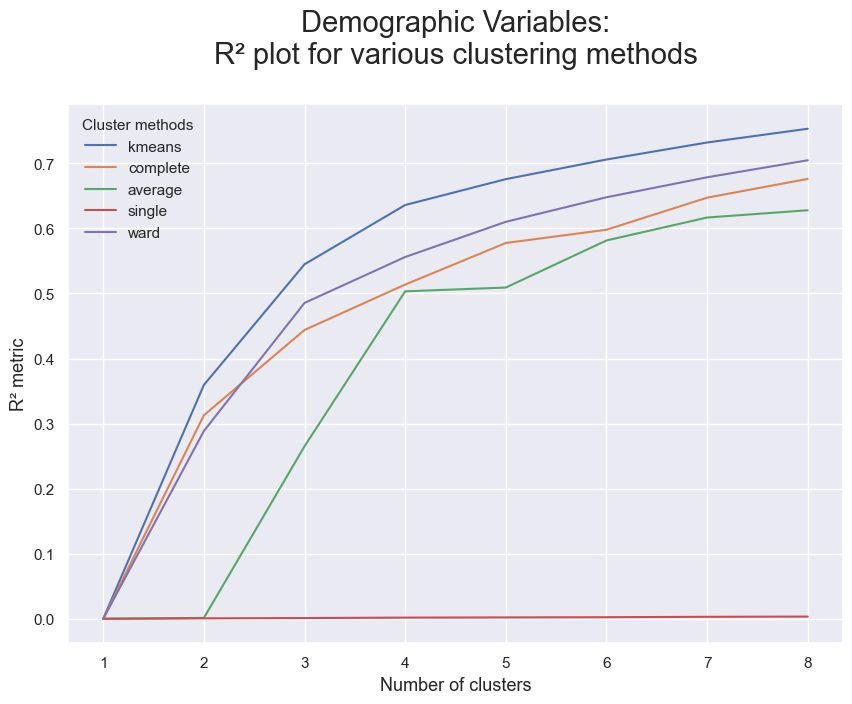

In [98]:
r2_scores_df.plot.line(figsize=(10,7))

plt.title("Demographic Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

The comparison identifies K-Means as the best algorithm for this dataset, since it achieves the highest R^2 scores across all cluster counts.
Analyzing the elbow of the curve reveals that 4 clusters is the optimal solution.

In [99]:
df_sample_value_viz = df_value_kmeans_hc.sample(n=3000, random_state=42)

To optimize processing time, we will generate the Silhouette plot using a random subset of 3,000 customers.

c:\Users\Asus\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.



For n_clusters = 2, the average score is: 0.3075


c:\Users\Asus\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.



For n_clusters = 3, the average score is: 0.3119


c:\Users\Asus\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.



For n_clusters = 4, the average score is: 0.3187


c:\Users\Asus\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.



For n_clusters = 5, the average score is: 0.2723


c:\Users\Asus\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.



For n_clusters = 6, the average score is: 0.2561


c:\Users\Asus\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.



For n_clusters = 7, the average score is: 0.2480


c:\Users\Asus\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.



For n_clusters = 8, the average score is: 0.2608


c:\Users\Asus\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.



For n_clusters = 9, the average score is: 0.2572


c:\Users\Asus\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.



For n_clusters = 10, the average score is: 0.2554


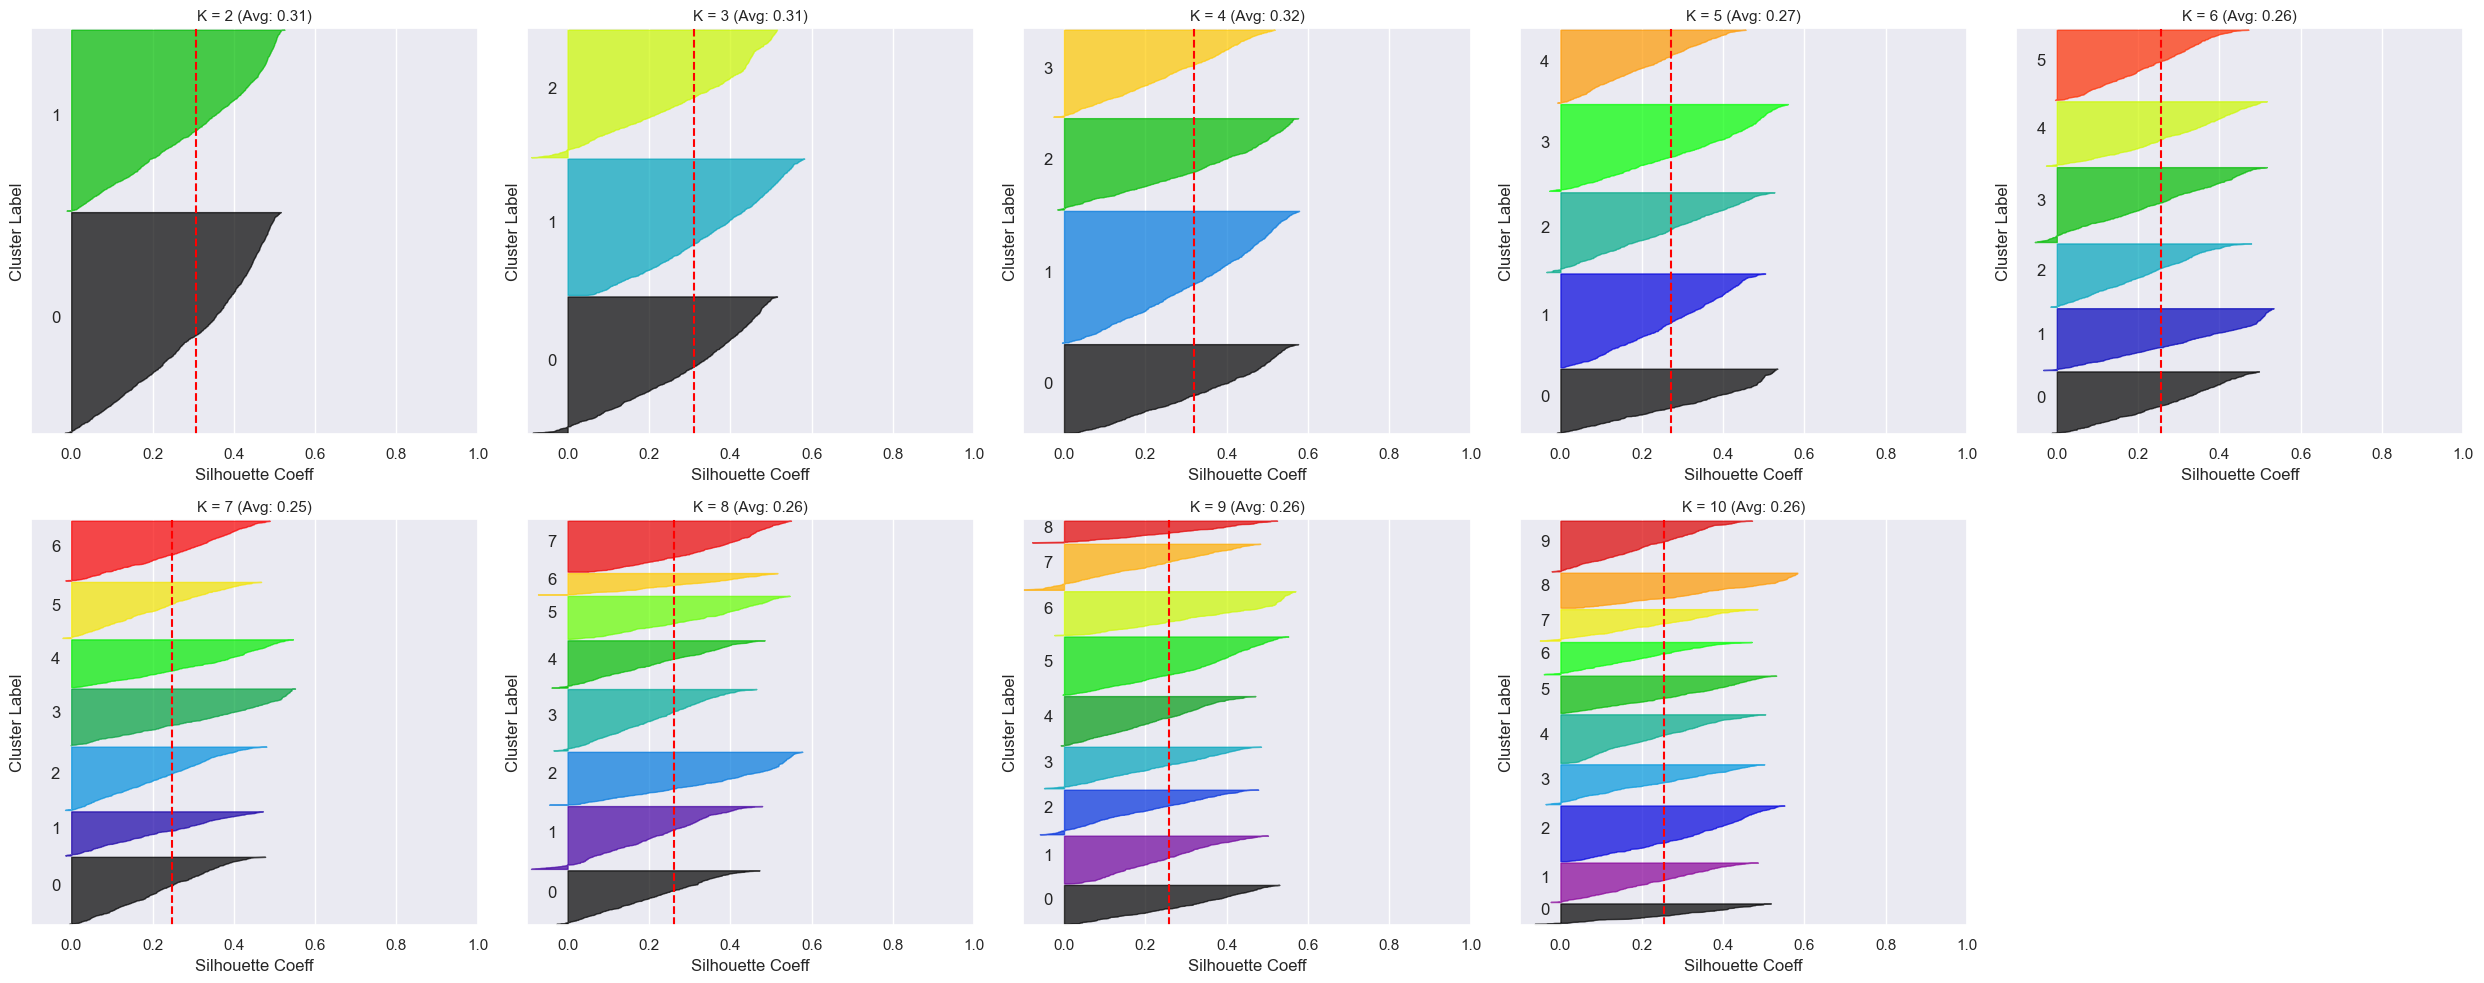

In [100]:
func.visualize_silhouette_graf(df_sample_value_viz, range_clusters=range(2, 11))

MUDAR Although R^2 plot pointed towards a 4-cluster solution, the analysis of the Silhouette Plot favored k=3.
Since the Silhouette score dropped when moving from 3 to 4 clusters (indicating less separation between groups), we chose the Elbow suggestion. We selected k=3 as the final solution to guarantee the most reliable and distinct separation of customer value tiers.

#### 7.1.2 DBSCAN

In [101]:
dbscan_value = DBSCAN(eps=1.8, min_samples=7, n_jobs=-1)

df_value_dbscan = dbscan_value.fit_predict(customer[features_val])

In [102]:
np.unique(df_value_dbscan)

array([0])

In [103]:
df_concat_value = pd.concat([customer[features_val], pd.Series(df_value_dbscan, index=customer.index, name="df_value_dbscan")], axis=1)
df_concat_value

,CLV,Income,PointsUtilizationRate,Tenure,df_value_dbscan
9494,-2.111388,-0.779707,-0.592971,-1.641869,0
10877,-0.982344,1.383990,-0.592971,-1.641869,0
427,-1.867423,-0.312172,-0.592971,-1.641869,0
7985,-2.353291,-1.243288,-0.592971,-1.641869,0
11944,0.045160,1.192490,-0.132972,-1.641869,0
...,...,...,...,...,...
7976,0.303178,-1.243288,-0.217197,1.785661,0
13107,0.697483,-0.440520,-0.074309,1.787053,0
6173,1.177678,0.478834,-0.196083,1.788445,0
11788,1.485031,1.099852,-0.123669,1.788445,0


In [104]:
df_concat_value['df_value_dbscan'].value_counts().sort_index()

df_value_dbscan
0    14989
Name: count, dtype: int64

In [105]:
dbscan_val = customer[features_val].copy()
dbscan_val['dbscan_labels'] = df_value_dbscan
r2_db = func.get_rsq(dbscan_val, features_val, 'dbscan_labels')

print(f"DBSCAN R² score: {r2_db:.4f}")

DBSCAN R² score: 0.0000


#### 7.1.3 HDBSCAN

In [106]:
hdb_value = HDBSCAN(
    min_cluster_size=200, 
    min_samples=7,       
    metric='euclidean',
    cluster_selection_method='eom' 
)

df_hdb_value = hdb_value.fit_predict(customer[features_val])
results_hdb_value = customer.copy()
results_hdb_value["Cluster_value_HDBSCAN"] = df_hdb_value

#  label -1 --> ruído
print(results_hdb_value["Cluster_value_HDBSCAN"].value_counts().sort_index())

Cluster_value_HDBSCAN
-1    1010
 0     270
 1    3410
 2    9431
 3     868
Name: count, dtype: int64


#### 7.1.4 Mean-shift

In [ ]:
df_value_meanshift= customer.copy()
df_value_meanshift['Cluster_MS_val'] = get_meanshift(customer, features_val)

Used quantile 0.08 -> 2 clusters found.


In [ ]:
print(df_value_meanshift.groupby('Cluster_MS_val')[features_val].mean())
print("\nCluster Sizes:")
print(df_value_meanshift.groupby('Cluster_MS_val').size())

                       CLV    Income  PointsUtilizationRate    Tenure
Cluster_MS_Valor                                                     
0                 0.510191  0.086014              -0.013857  0.500051
1                -1.036212 -0.252045              -0.188918 -1.093373

Cluster Sizes:
Cluster_MS_Valor
0    10978
1     4011
dtype: int64


#### 7.1.5 Gaussian Mixture Model

### 7.2 Behavioral Segmentation perspective

#### 7.2.1 K-means with Hierarchical clustering

In [108]:
features_behave = clustering_perspectives['Behavioral_Segmentation']
df_behave_kmeans_hc = customer[features_behave].copy()
df_behave_kmeans_hc

,NumFlights,Avg_Distance_Flight,recency_months,Companion_Ratio,Flight_Trend_Slope,Fall_Ratio,Spring_Ratio,Summer_Ratio,Winter_Ratio,Seasonality_Index
9494,-1.755792,-1.493399,-0.606190,-1.696969,-0.544848,-1.360274,-1.418826,-1.660585,-1.278877,-1.469139
10877,-1.755792,-1.493399,-0.606190,-1.696969,-0.544848,-1.360274,-1.418826,-1.660585,-1.278877,-1.469139
427,-1.755792,-1.493399,-0.606190,-1.696969,-0.544848,-1.360274,-1.418826,-1.660585,-1.278877,-1.469139
7985,-1.755792,-1.493399,-0.606190,-1.696969,-0.544848,-1.360274,-1.418826,-1.660585,-1.278877,-1.469139
11944,-0.043547,0.808583,-0.021519,-0.927038,-0.016736,-0.434689,1.755045,-0.280373,-0.200695,0.013929
...,...,...,...,...,...,...,...,...,...,...
7976,0.539885,0.541788,-0.313854,-0.343360,-0.713790,0.710787,0.226213,-0.332275,-0.039116,-0.617447
13107,0.501835,-0.320906,-0.313854,-0.320547,0.285232,0.812549,0.988324,-1.052771,-0.052293,-0.063100
6173,0.501835,-0.079830,-0.313854,-0.487386,-0.084579,0.177416,0.947524,-0.816399,0.390640,-0.249739
11788,0.476469,-0.354792,-0.313854,-0.473641,1.556957,0.769624,-0.882410,0.695844,-0.210650,-0.244417


In [109]:
df_behave_sample = df_behave_kmeans_hc.sample(n=5000, random_state=42)

In [110]:
r2_scores_behave = {}

r2_scores_behave['kmeans'] = func.get_r2_scores(df_behave_sample, df_behave_kmeans_hc.columns.tolist(), kmeans)

for linkage in ['complete', 'average', 'single', 'ward']: # 4 different versions of HC
    r2_scores_behave[linkage] = func.get_r2_scores(
        df_behave_sample,                 # data
        df_behave_kmeans_hc.columns.tolist(),   # features of perspective
        # use HClust, changing the linkage at each iteration
        hierarchical.set_params(linkage=linkage) 
    )

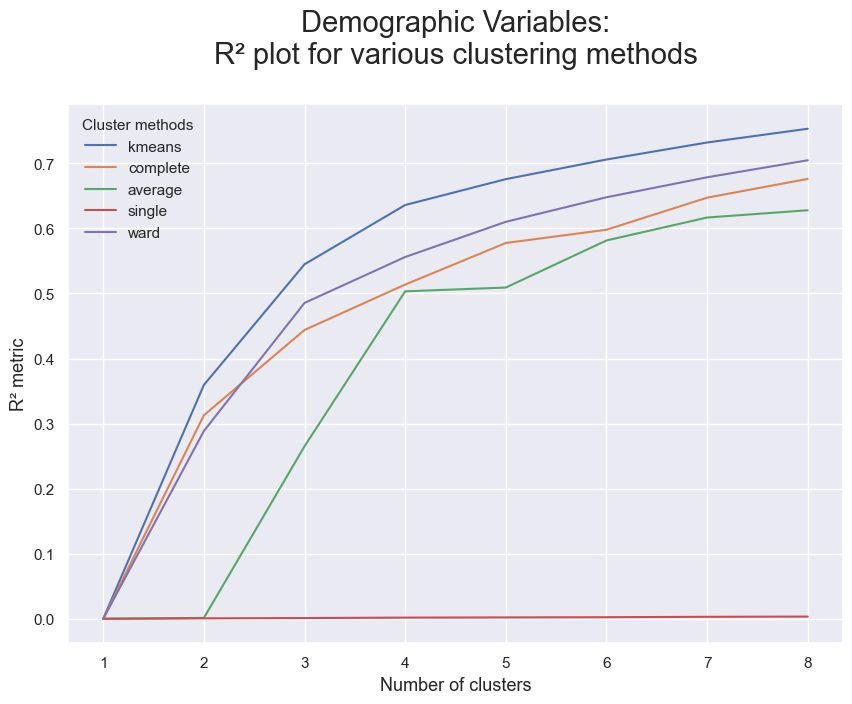

In [111]:
r2_scores_df_behave = pd.DataFrame(r2_scores)

r2_scores_df_behave.plot.line(figsize=(10,7))

plt.title("Demographic Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

The comparison of clustering algorithms reveals that K-Means outperforms other methods, achieving the highest explained variance across all k values. Regarding the number of clusters, we identify a elbow at k=4. The model explains mora then 60% of the behavioral variance at this point.

In [112]:
df_sample_behave_viz = df_behave_kmeans_hc.sample(n=3000, random_state=42)

To optimize processing time, we will generate the Silhouette plot using a random subset of 3,000 customers.

c:\Users\Asus\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.



For n_clusters = 2, the average score is: 0.4979


c:\Users\Asus\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.



For n_clusters = 3, the average score is: 0.3682


c:\Users\Asus\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.



For n_clusters = 4, the average score is: 0.3077


c:\Users\Asus\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.



For n_clusters = 5, the average score is: 0.3045


c:\Users\Asus\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.



For n_clusters = 6, the average score is: 0.2206


c:\Users\Asus\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.



For n_clusters = 7, the average score is: 0.2191


c:\Users\Asus\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.



For n_clusters = 8, the average score is: 0.2213


c:\Users\Asus\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.



For n_clusters = 9, the average score is: 0.2131


c:\Users\Asus\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.



For n_clusters = 10, the average score is: 0.2167


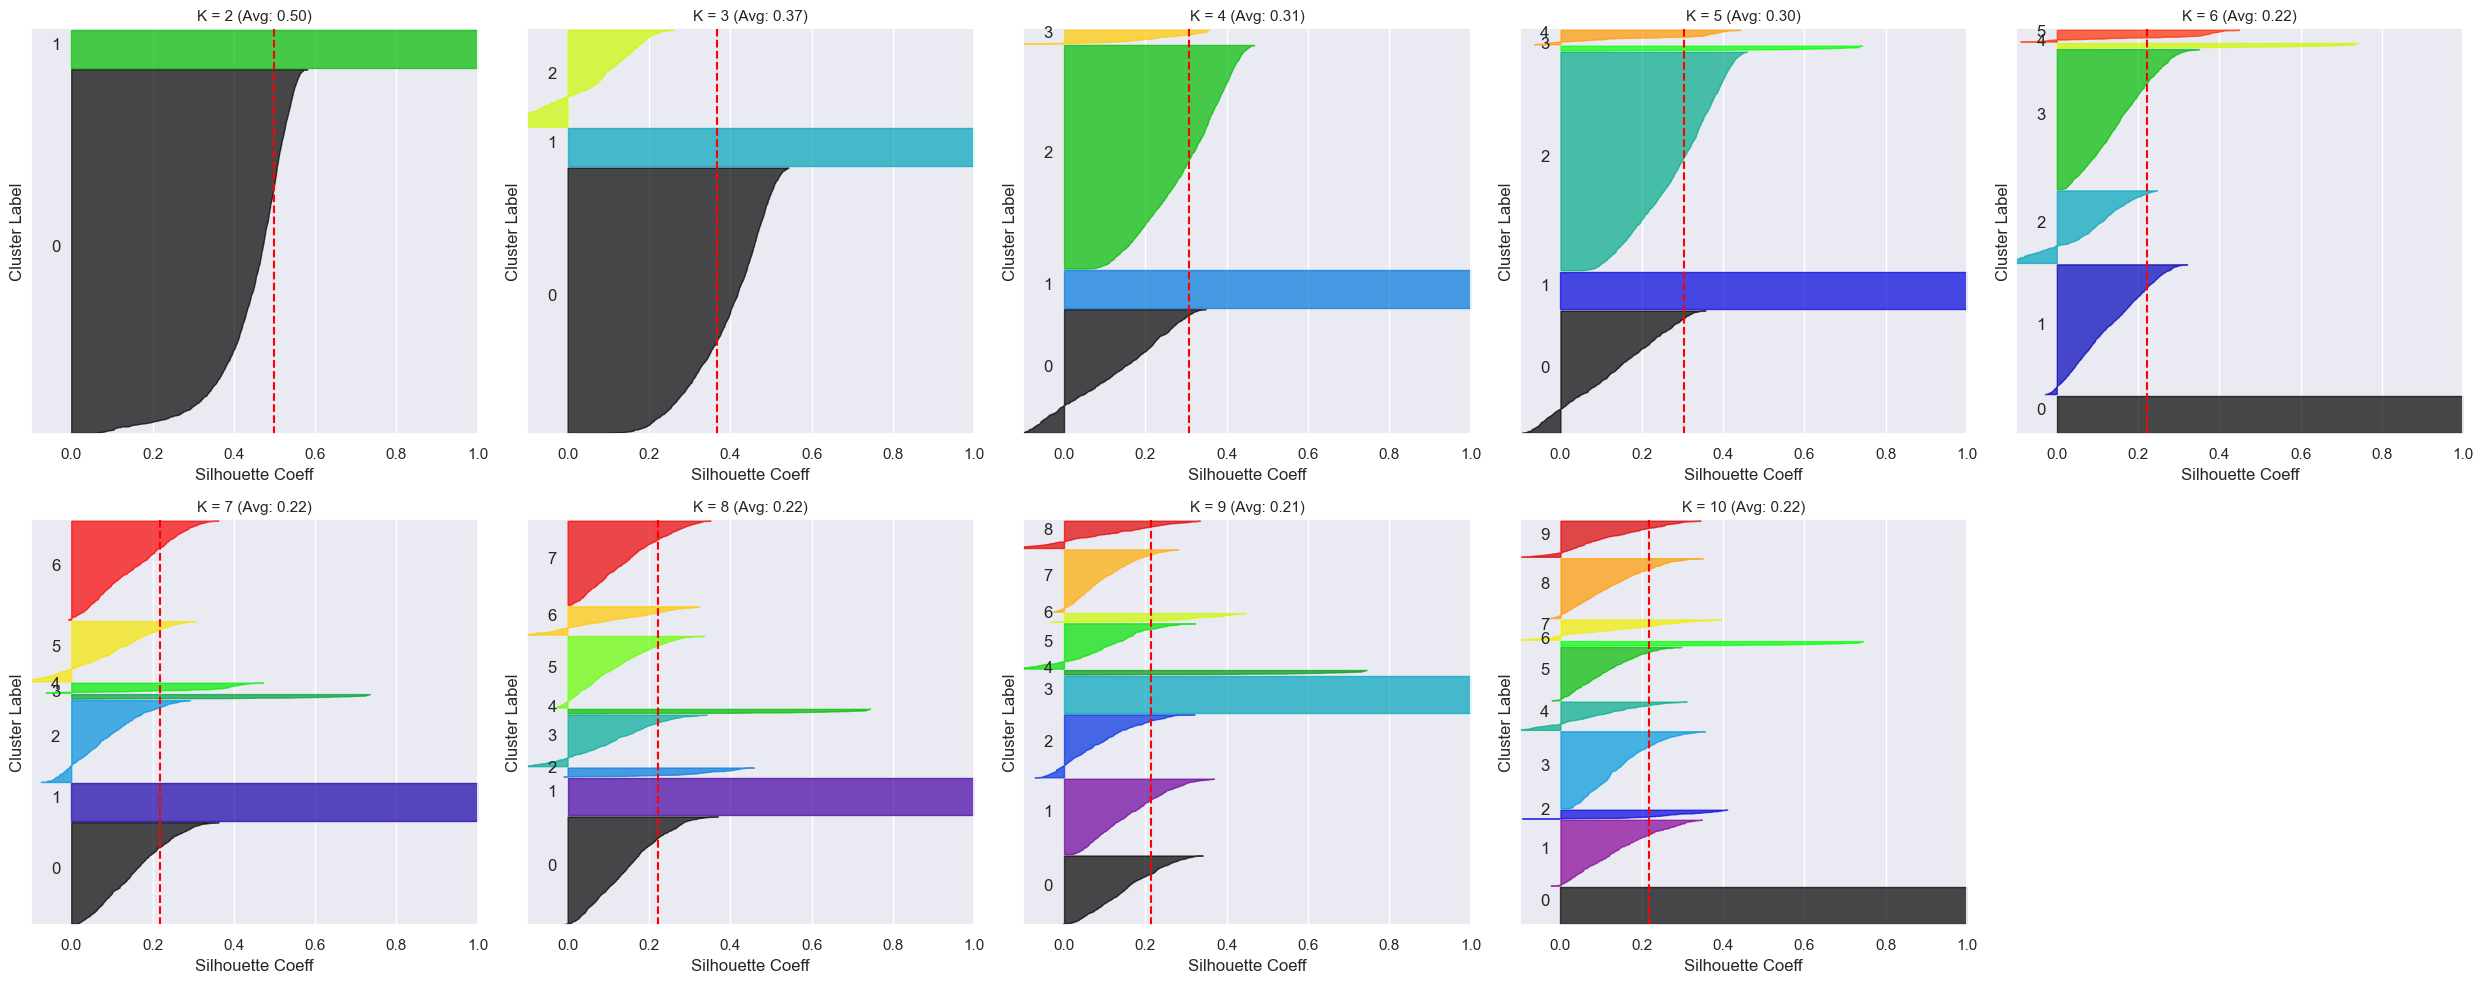

In [113]:
func.visualize_silhouette_graf(df_sample_behave_viz, range_clusters=range(2, 11))

mudar esta conclusao

Although the Silhouette analysis indicates a mathematical peak at k=3, we rejected this solution as it results in an oversimplified binary segmentation ( merely separating high vs. low values). We selected k=4 because it offers the optimal balance between statistical validity and business utility, allowing us to identify distinct niche profiles that would otherwise be merged in a 2-cluster solution.

#### 7.2.2 DBSCAN

In [114]:
dbscan_behave = DBSCAN(eps=1.8, min_samples=9, n_jobs=-1)

df_behave_dbscan = dbscan_value.fit_predict(customer[features_behave])

In [115]:
np.unique(df_behave_dbscan)

array([0, 1])

In [116]:
df_concat_behave = pd.concat([customer[features_behave], pd.Series(df_behave_dbscan, index=customer.index, name="df_behave_dbscan")], axis=1)
df_concat_behave

,NumFlights,Avg_Distance_Flight,recency_months,Companion_Ratio,Flight_Trend_Slope,Fall_Ratio,Spring_Ratio,Summer_Ratio,Winter_Ratio,Seasonality_Index,df_behave_dbscan
9494,-1.755792,-1.493399,-0.606190,-1.696969,-0.544848,-1.360274,-1.418826,-1.660585,-1.278877,-1.469139,0
10877,-1.755792,-1.493399,-0.606190,-1.696969,-0.544848,-1.360274,-1.418826,-1.660585,-1.278877,-1.469139,0
427,-1.755792,-1.493399,-0.606190,-1.696969,-0.544848,-1.360274,-1.418826,-1.660585,-1.278877,-1.469139,0
7985,-1.755792,-1.493399,-0.606190,-1.696969,-0.544848,-1.360274,-1.418826,-1.660585,-1.278877,-1.469139,0
11944,-0.043547,0.808583,-0.021519,-0.927038,-0.016736,-0.434689,1.755045,-0.280373,-0.200695,0.013929,1
...,...,...,...,...,...,...,...,...,...,...,...
7976,0.539885,0.541788,-0.313854,-0.343360,-0.713790,0.710787,0.226213,-0.332275,-0.039116,-0.617447,1
13107,0.501835,-0.320906,-0.313854,-0.320547,0.285232,0.812549,0.988324,-1.052771,-0.052293,-0.063100,1
6173,0.501835,-0.079830,-0.313854,-0.487386,-0.084579,0.177416,0.947524,-0.816399,0.390640,-0.249739,1
11788,0.476469,-0.354792,-0.313854,-0.473641,1.556957,0.769624,-0.882410,0.695844,-0.210650,-0.244417,1


In [117]:
df_concat_behave['df_behave_dbscan'].value_counts().sort_index()

df_behave_dbscan
0     1473
1    13516
Name: count, dtype: int64

In [118]:
dbscan_behave = customer[features_behave].copy()
dbscan_behave['dbscan_labels'] = df_behave_dbscan
r2_db = func.get_rsq(dbscan_behave, features_behave, 'dbscan_labels')

print(f"DBSCAN R² score: {r2_db:.4f}")

DBSCAN R² score: 0.2980


#### 7.2.3 HDBSCAN

In [126]:
hdb_behave = HDBSCAN(
    min_cluster_size=200, 
    min_samples=9,       
    metric='euclidean',
    cluster_selection_method='eom' 
)

df_hdb_behave = hdb_behave.fit_predict(customer[features_behave])
results_hdb_behave = customer.copy()
results_hdb_behave["Cluster_behave_HDBSCAN"] = df_hdb_behave

#  label -1 --> ruído
print(results_hdb_behave["Cluster_behave_HDBSCAN"].value_counts().sort_index())

Cluster_behave_HDBSCAN
0     1473
1    13516
Name: count, dtype: int64


#### 7.2.4 Mean-shift

In [127]:
df_behave_meanshift= customer.copy()
df_behave_meanshift['Cluster_MS_behave'] = get_meanshift(customer, features_behave)

Used quantile 0.25 -> 3 clusters found.


In [ ]:
print(df_behave_meanshift.groupby('Cluster_MS_behave')[features_behave].mean())
print("\nCluster Sizes:")
print(df_behave_meanshift.groupby('Cluster_MS_behave').size())

                   NumFlights  Avg_Distance_Flight  recency_months  \
Cluster_MS_behave                                                    
0                    0.177525            -0.073697       -0.215516   
1                   -1.425634            -0.032002       -0.185016   
2                   -1.574377            -0.091971       -0.313854   

                   Companion_Ratio  Flight_Trend_Slope  Fall_Ratio  \
Cluster_MS_behave                                                    
0                        -0.060657            0.054387   -0.094336   
1                        -0.278609            0.469315    3.035666   
2                        -0.721530            0.101809   -0.672288   

                   Spring_Ratio  Summer_Ratio  Winter_Ratio  Seasonality_Index  
Cluster_MS_behave                                                               
0                      0.048192      0.088784     -0.115051          -0.276844  
1                     -1.381572     -1.302014     -0.08

Cluster_MS_behave
0    14400
1      388
2      201
dtype: int64

#### 7.2.5 Gaussian Mixture Model

### 7.3 Final Clustering Solution

In [ ]:

kmeans_value = KMeans(
    n_clusters=4,
    init='k-means++',
    n_init=20,
    random_state=42
)
#value_labels = kmeans_value.fit_predict(df_value)
#value_labels

NameError: name 'df_value' is not defined

: 

: 

: 

: 

In [ ]:
#customer['value_cluster'] = value_labels

: 

: 

: 

: 

In [ ]:
kmeans_behave = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=20,
    random_state=42
)
#behave_labels = kmeans_behave.fit_predict(df_behave)
#behave_labels

array([2, 2, 2, ..., 1, 0, 2], dtype=int32)

: 

: 

: 

: 

In [ ]:
#customer['behavioral_cluster'] = behave_labels

: 

: 

: 

: 

In [ ]:
#print(f"Behavioral clusters: {customer['value_cluster'].nunique()}")
#print(f"Preference clusters: {customer['behavioral_cluster'].nunique()}")

Behavioral clusters: 4
Preference clusters: 3


: 

: 

: 

: 

In [ ]:
#crosstab = pd.crosstab(customer['value_cluster'], customer['behavioral_cluster'])
#crosstab

behavioral_cluster,0,1,2
value_cluster,,,
0,1857,997,564
1,187,3106,157
2,1233,1665,296
3,289,4182,456


: 

: 

: 

: 

reavaliar os graficos seguintes apos o features selection

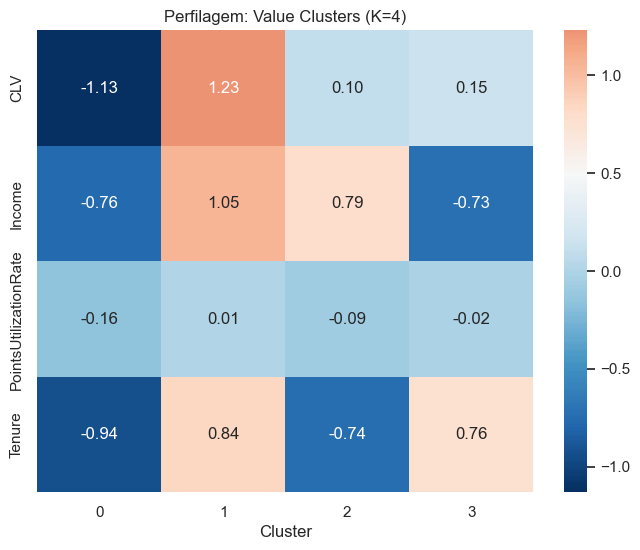

: 

: 

: 

: 

In [ ]:
cols_value = df_value.columns.tolist() 
temp_df = customer[cols_value].copy()
temp_df['Cluster'] = customer['value_cluster']

# Agrupar e calcular média
profile_value = temp_df.groupby('Cluster').mean().T

# Desenhar
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(profile_value, center=0.5, annot=True, cmap="RdBu_r", fmt=".2f", ax=ax)
ax.set_title("Perfilagem: Value Clusters (K=4)")
plt.show()

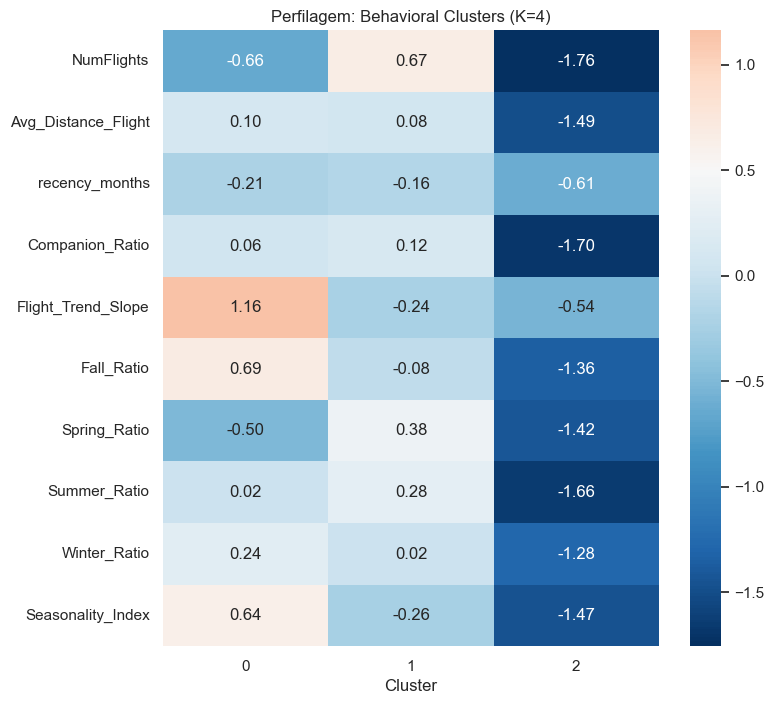

: 

: 

: 

: 

In [ ]:
cols_behave = df_behave.columns.tolist()
temp_df_b = customer[cols_behave].copy()
temp_df_b['Cluster'] = customer['behavioral_cluster']

# Agrupar e calcular média
profile_behave = temp_df_b.groupby('Cluster').mean().T

# Desenhar
fig, ax = plt.subplots(figsize=(8, 8)) # Mais alto porque deve ter mais variáveis
sns.heatmap(profile_behave, center=0.5, annot=True, cmap="RdBu_r", fmt=".2f", ax=ax)
ax.set_title("Perfilagem: Behavioral Clusters (K=4)")
plt.show()

### 7.4 Merge clusters using Hierarchical Clustering

In [ ]:
df_centroids = customer.groupby(['value_cluster', 'behavioral_cluster'])[fs_metric_features].mean()
df_centroids

Income       CLV  NumFlights  Fall_Ratio  \
value_cluster behavioral_cluster                                               
0             0                  -0.675054 -1.306278   -0.865618    0.732887   
              1                  -1.017641 -0.493900    0.420710   -0.070471   
              2                  -0.608421 -1.678682   -1.755792   -1.360274   
1             0                   1.081649  0.962853    0.128051    0.505978   
              1                   1.029623  1.309858    0.759058   -0.070174   
              2                   1.343247 -0.036990   -1.755792   -1.360274   
2             0                   0.987608 -0.251396   -0.639199    0.681747   
              1                   0.587470  0.490310    0.581157   -0.061823   
              2                   1.128744 -0.667837   -1.755792   -1.360274   
3             0                  -0.699501 -0.058612    0.079907    0.521907   
              1                  -0.765859  0.292254    0.687921   -0.087974   
              2                  -0.420031 -0.980410   -1.755792   -1.360274   

                                  Spring_Ratio  Summer_Ratio  Winter_Ratio  \
value_cluster behavioral_cluster                                             
0             0                      -0.560005     -0.081660      0.342064   
              1                       0.425649      0.317077     -0.064568   
              2                      -1.418826     -1.660585     -1.278877   
1             0                      -0.283212      0.070235      0.188925   
              1                       0.359868      0.278852      0.028633   
              2                      -1.418826     -1.660585     -1.278877   
2             0                      -0.506561      0.149260      0.116555   
              1                       0.370958      0.323318     -0.034007   
              2                      -1.418826     -1.660585     -1.278877   
3             0                      -0.271180      0.092515      0.140161   
              1                       0.382617      0.261297      0.045491   
              2                      -1.418826     -1.660585     -1.278877   

                                  Seasonality_Index  Flight_Trend_Slope  \
value_cluster behavioral_cluster                                          
0             0                            0.871298            1.143401   
              1                           -0.160220           -0.059643   
              2                           -1.469139           -0.544848   
1             0                           -0.102919            1.038221   
              1                           -0.303522           -0.273198   
              2                           -1.469139           -0.544848   
2             0                            0.560503            1.258925   
              1                           -0.214400           -0.140459   
              2                           -1.469139           -0.544848   
3             0                           -0.068297            0.959806   
              1                           -0.272627           -0.290987   
              2                           -1.469139           -0.544848   

                                  Companion_Ratio  Avg_Distance_Flight  \
value_cluster behavioral_cluster                                         
0             0                          0.030525             0.065529   
              1                          0.132875             0.149423   
              2                         -1.696969            -1.493399   
1             0                          0.248193             0.265776   
              1                          0.120737             0.052395   
              2                         -1.696969            -1.493399   
2             0                          0.022061             0.072476   
              1                          0.115556             0.091225   
              2                

: 

: 

: 

: 

In [ ]:
print(f"\nCentroids shape: {df_centroids.shape}")


Centroids shape: (12, 14)


: 

: 

: 

: 

In [ ]:
# Fit hierarchical clustering with distance tracking
hclust = AgglomerativeClustering(
    linkage='ward',
    metric='euclidean',
    distance_threshold=0,
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

# Build linkage matrix for dendrogram
# (Adapted from scikit-learn documentation)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1 
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([
    hclust.children_,
    hclust.distances_,
    counts
]).astype(float)

print("Linkage matrix ready for dendrogram!")

Linkage matrix ready for dendrogram!


: 

: 

: 

: 

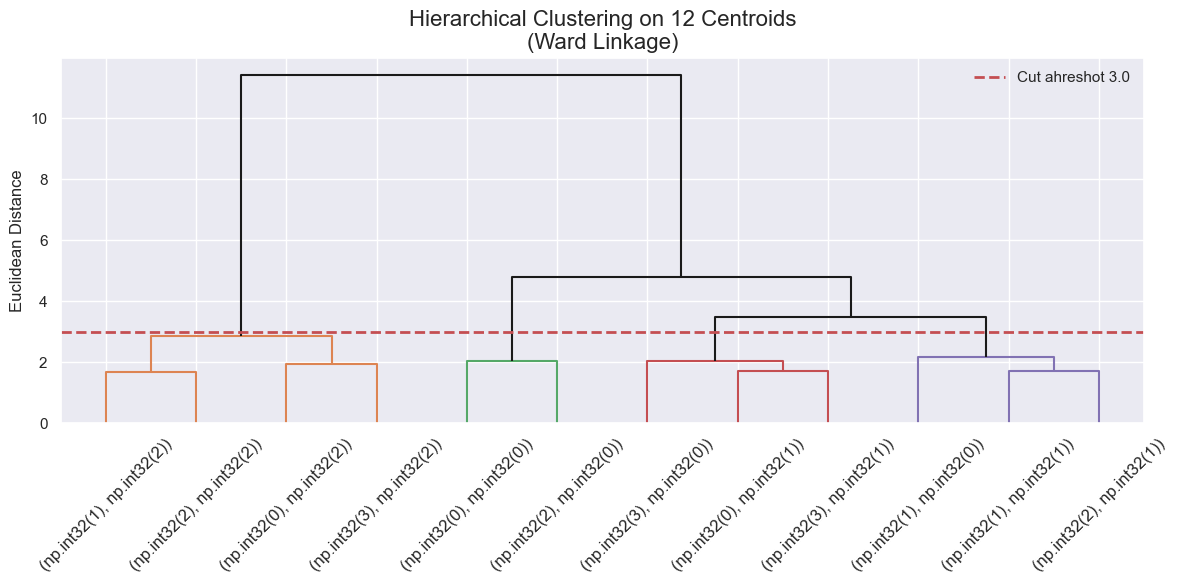

: 

: 

: 

: 

In [ ]:
fig = plt.figure(figsize=(12, 6))

y_threshold = 3.0 # Can adjust this!

dendrogram(
    linkage_matrix,
    labels=df_centroids.index,
    color_threshold=y_threshold,
    above_threshold_color='k'
)

plt.axhline(y=y_threshold, color='r', linestyle='--', linewidth=2, label=f'Cut ahreshot {y_threshold}')

plt.title(f'Hierarchical Clustering on 12 Centroids\n(Ward Linkage)', fontsize=16)
plt.ylabel('Euclidean Distance')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
n_final_clusters = 4

hclust_final = AgglomerativeClustering(
    linkage='ward',
    n_clusters=n_final_clusters
)
hclust_final_labels=hclust_final.fit_predict(df_centroids)
hclust_final_labels

array([2, 3, 0, 1, 1, 0, 2, 1, 0, 3, 3, 0])

: 

: 

: 

: 

In [ ]:
df_centroids['merged_labels'] = hclust_final_labels
df_centroids

Income       CLV  NumFlights  Fall_Ratio  \
value_cluster behavioral_cluster                                               
0             0                  -0.675054 -1.306278   -0.865618    0.732887   
              1                  -1.017641 -0.493900    0.420710   -0.070471   
              2                  -0.608421 -1.678682   -1.755792   -1.360274   
1             0                   1.081649  0.962853    0.128051    0.505978   
              1                   1.029623  1.309858    0.759058   -0.070174   
              2                   1.343247 -0.036990   -1.755792   -1.360274   
2             0                   0.987608 -0.251396   -0.639199    0.681747   
              1                   0.587470  0.490310    0.581157   -0.061823   
              2                   1.128744 -0.667837   -1.755792   -1.360274   
3             0                  -0.699501 -0.058612    0.079907    0.521907   
              1                  -0.765859  0.292254    0.687921   -0.087974   
              2                  -0.420031 -0.980410   -1.755792   -1.360274   

                                  Spring_Ratio  Summer_Ratio  Winter_Ratio  \
value_cluster behavioral_cluster                                             
0             0                      -0.560005     -0.081660      0.342064   
              1                       0.425649      0.317077     -0.064568   
              2                      -1.418826     -1.660585     -1.278877   
1             0                      -0.283212      0.070235      0.188925   
              1                       0.359868      0.278852      0.028633   
              2                      -1.418826     -1.660585     -1.278877   
2             0                      -0.506561      0.149260      0.116555   
              1                       0.370958      0.323318     -0.034007   
              2                      -1.418826     -1.660585     -1.278877   
3             0                      -0.271180      0.092515      0.140161   
              1                       0.382617      0.261297      0.045491   
              2                      -1.418826     -1.660585     -1.278877   

                                  Seasonality_Index  Flight_Trend_Slope  \
value_cluster behavioral_cluster                                          
0             0                            0.871298            1.143401   
              1                           -0.160220           -0.059643   
              2                           -1.469139           -0.544848   
1             0                           -0.102919            1.038221   
              1                           -0.303522           -0.273198   
              2                           -1.469139           -0.544848   
2             0                            0.560503            1.258925   
              1                           -0.214400           -0.140459   
              2                           -1.469139           -0.544848   
3             0                           -0.068297            0.959806   
              1                           -0.272627           -0.290987   
              2                           -1.469139           -0.544848   

                                  Companion_Ratio  Avg_Distance_Flight  \
value_cluster behavioral_cluster                                         
0             0                          0.030525             0.065529   
              1                          0.132875             0.149423   
              2                         -1.696969            -1.493399   
1             0                          0.248193             0.265776   
              1                          0.120737             0.052395   
              2                         -1.696969            -1.493399   
2             0                          0.022061             0.072476   
              1                          0.115556             0.091225   
              2                

: 

: 

: 

: 

In [ ]:
cluster_mapper = df_centroids['merged_labels'].to_dict()
cluster_mapper  

{(0, 0): 2,
 (0, 1): 3,
 (0, 2): 0,
 (1, 0): 1,
 (1, 1): 1,
 (1, 2): 0,
 (2, 0): 2,
 (2, 1): 1,
 (2, 2): 0,
 (3, 0): 3,
 (3, 1): 3,
 (3, 2): 0}

: 

: 

: 

: 

In [ ]:
customer['merged_labels'] = customer.apply(
    lambda row: cluster_mapper[(row['value_cluster'], row['behavioral_cluster'])],
    axis=1
)
customer

,Income,CLV,NumFlights,Fall_Ratio,Spring_Ratio,Summer_Ratio,Winter_Ratio,Seasonality_Index,Flight_Trend_Slope,Companion_Ratio,...,oh_Whitehorse,oh_Winnipeg,R_quintile,F_quintile,M_quintile,RFM_score,RFM_segment,value_cluster,behavioral_cluster,merged_labels
9494,-0.779707,-2.111388,-1.755792,-1.360274,-1.418826,-1.660585,-1.278877,-1.469139,-0.544848,-1.696969,...,0,0,5,1,1,511,New customers,0,2,0
10877,1.383990,-0.982344,-1.755792,-1.360274,-1.418826,-1.660585,-1.278877,-1.469139,-0.544848,-1.696969,...,0,0,5,1,1,511,New customers,2,2,0
427,-0.312172,-1.867423,-1.755792,-1.360274,-1.418826,-1.660585,-1.278877,-1.469139,-0.544848,-1.696969,...,0,0,5,1,1,511,New customers,0,2,0
7985,-1.243288,-2.353291,-1.755792,-1.360274,-1.418826,-1.660585,-1.278877,-1.469139,-0.544848,-1.696969,...,0,0,5,1,1,511,New customers,0,2,0
11944,1.192490,0.045160,-0.043547,-0.434689,1.755045,-0.280373,-0.200695,0.013929,-0.016736,-0.927038,...,0,0,1,2,3,123,Others,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7976,-1.243288,0.303178,0.539885,0.710787,0.226213,-0.332275,-0.039116,-0.617447,-0.713790,-0.343360,...,0,0,5,4,3,543,Others,3,1,3
13107,-0.440520,0.697483,0.501835,0.812549,0.988324,-1.052771,-0.052293,-0.063100,0.285232,-0.320547,...,0,0,5,3,4,534,Others,3,1,3
6173,0.478834,1.177678,0.501835,0.177416,0.947524,-0.816399,0.390640,-0.249739,-0.084579,-0.487386,...,0,0,5,3,5,535,Big spenders,1,1,1
11788,1.099852,1.485031,0.476469,0.769624,-0.882410,0.695844,-0.210650,-0.244417,1.556957,-0.473641,...,0,0,5,3,5,535,Big spenders,1,0,1


: 

: 

: 

: 

In [ ]:
print(customer['merged_labels'].value_counts().sort_index())

merged_labels
0    1473
1    4958
2    3090
3    5468
Name: count, dtype: int64


: 

: 

: 

: 

In [ ]:
# Quick distinctiveness check (R²)
r2_merged = get_rsq(customer, fs_metric_features, 'merged_labels')
print(f"\nMerged clustering R²: {r2_merged:.4f}")


Merged clustering R²: 0.4574


: 

: 

: 

: 

## 8. Profiling

#### 8.1 Metric Features

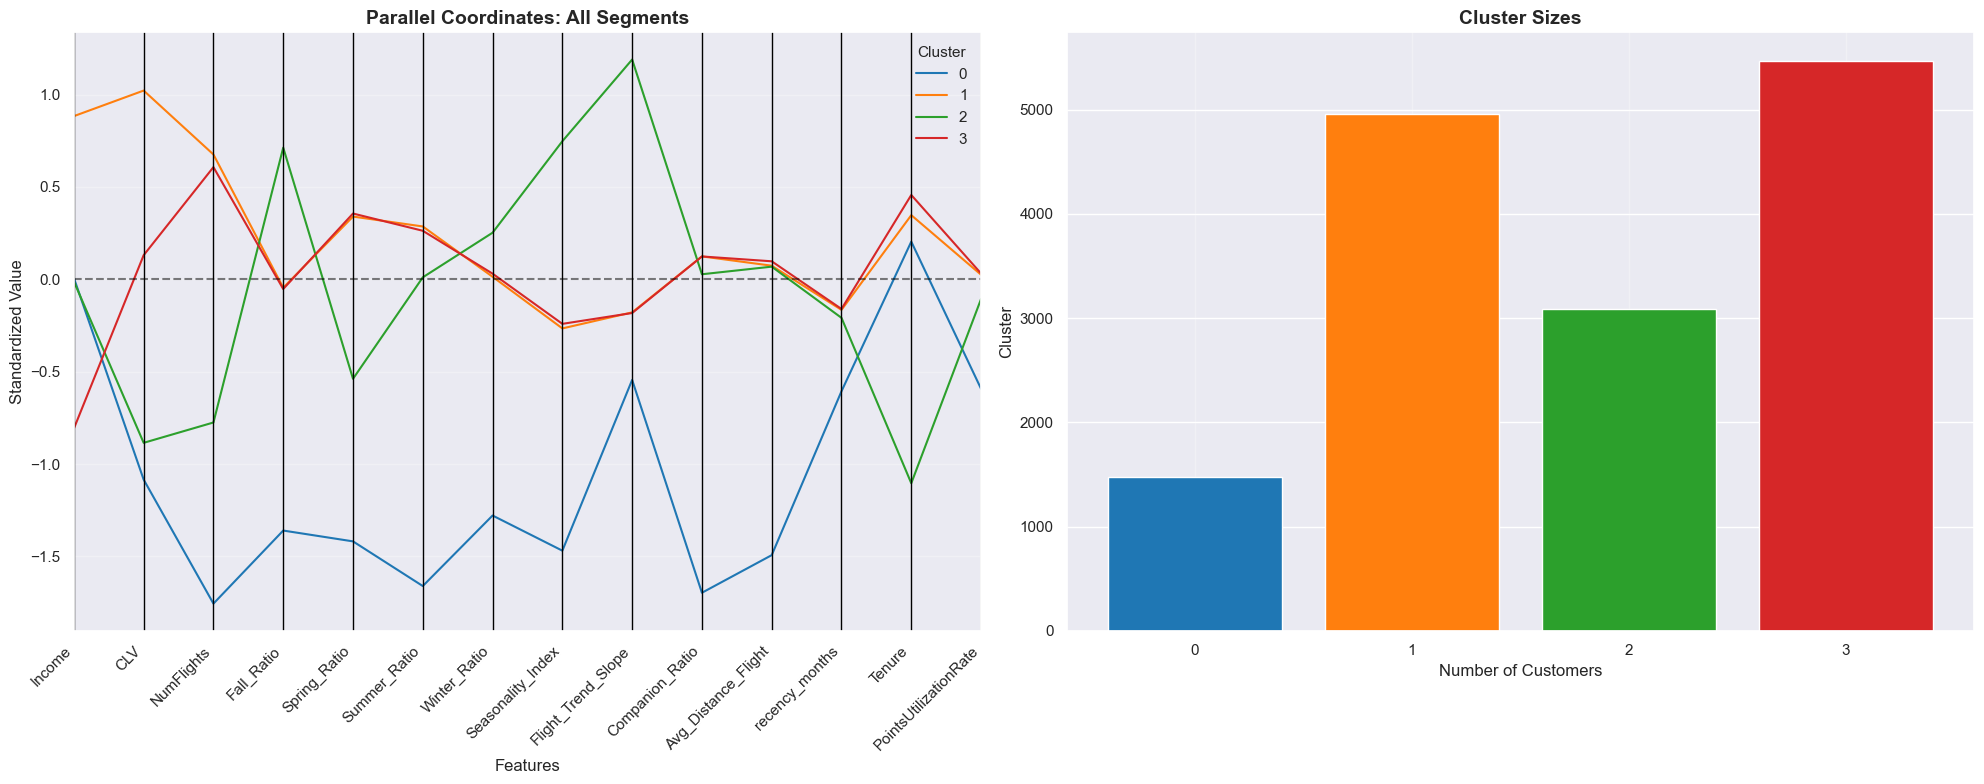

: 

: 

: 

: 

In [ ]:
# Get centroids for ALL segments
all_segments = sorted(customer['merged_labels'].unique())
df_all_centroids = customer.groupby('merged_labels')[fs_metric_features].mean()

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# LEFT PLOT: Parallel coordinates for all clusters
plt.sca(ax1)
pd.plotting.parallel_coordinates(
    df_all_centroids.reset_index(),
    'merged_labels',
    color=sns.color_palette('tab10', n_colors=len(all_segments)),
    ax=ax1
)
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1.5)
ax1.set_title('Parallel Coordinates: All Segments', fontsize=14, fontweight='bold')
ax1.set_ylabel('Standardized Value', fontsize=12)
ax1.set_xlabel('Features', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax1.legend(title='Cluster', loc='best', title_fontsize=11)
ax1.grid(True, alpha=0.3)

# RIGHT PLOT: Cluster sizes (ordered by cluster number)
cluster_sizes = customer['merged_labels'].value_counts().sort_index()
colors = sns.color_palette('tab10', n_colors=len(all_segments))

ax2.bar(cluster_sizes.index.astype(str), cluster_sizes.values, color=colors)
ax2.set_xlabel('Number of Customers', fontsize=12)
ax2.set_ylabel('Cluster', fontsize=12)
ax2.set_title('Cluster Sizes', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_25952\2565072123.py:26: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




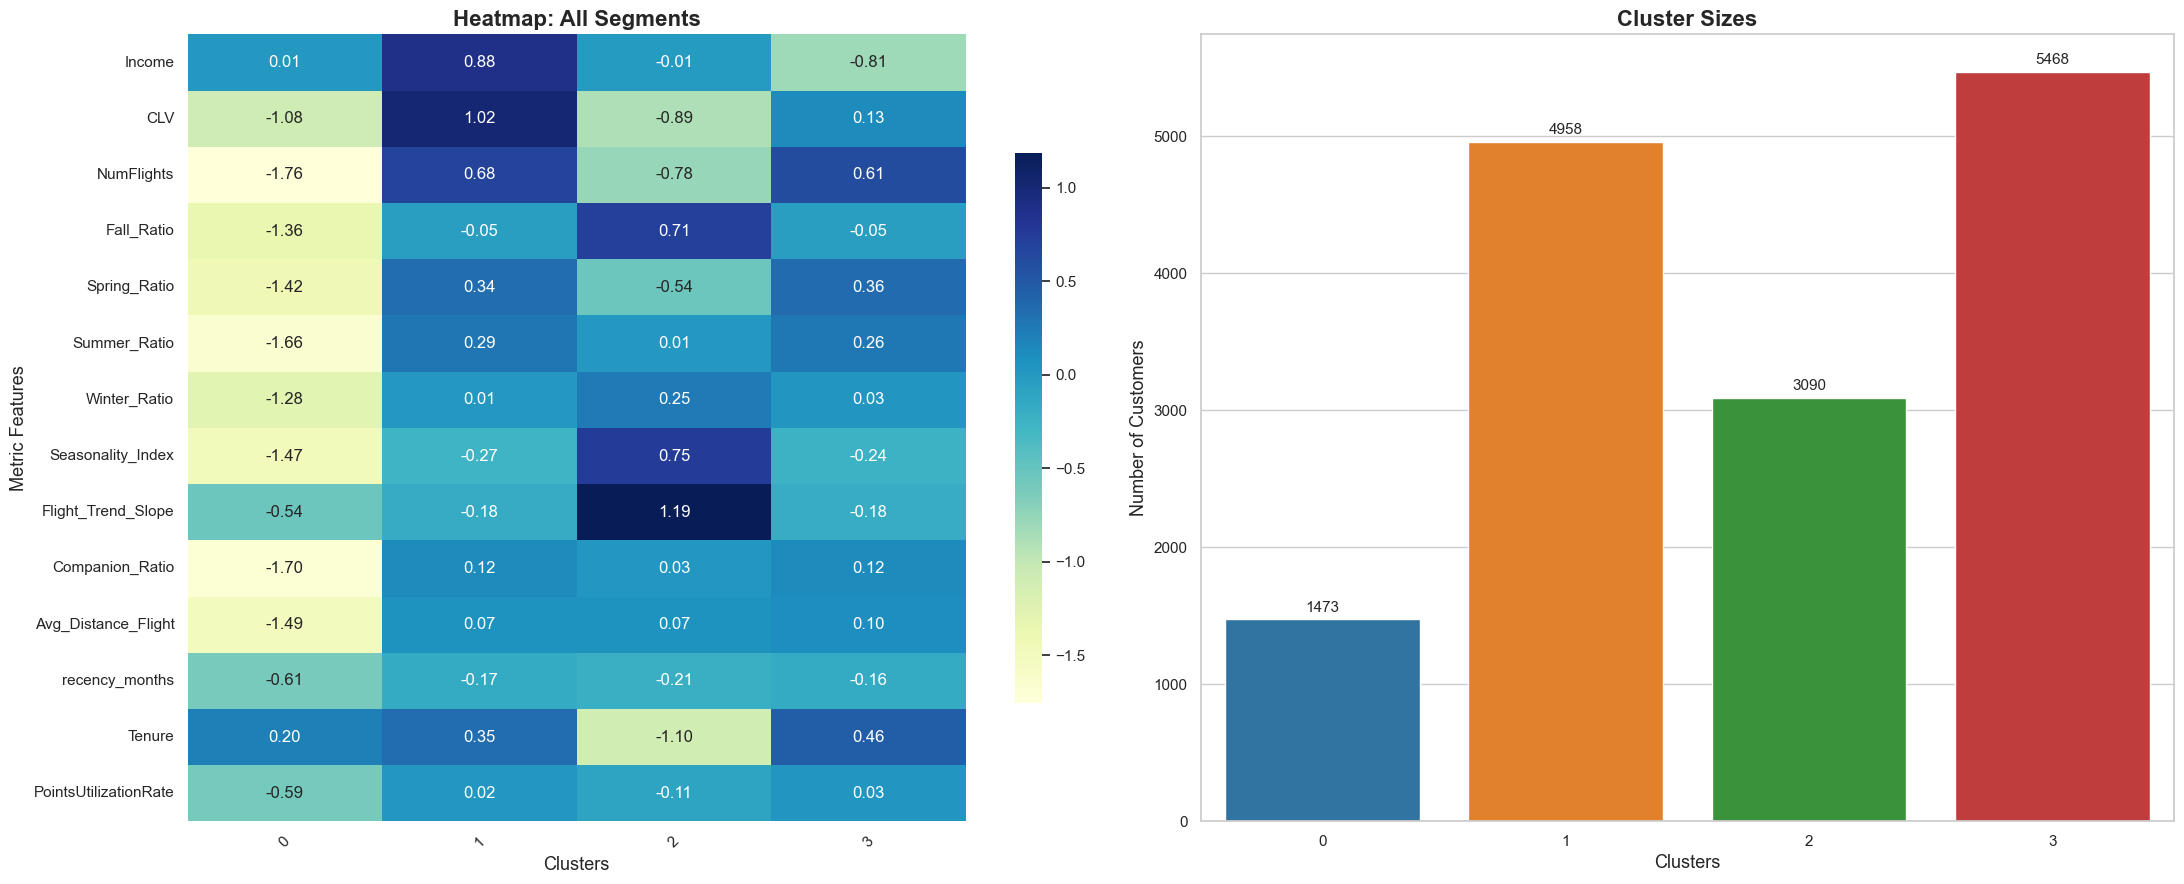

: 

: 

: 

: 

In [ ]:
sns.set_style("whitegrid")

all_segments = sorted(customer['merged_labels'].unique())
df_all_centroids = customer.groupby('merged_labels')[fs_metric_features].mean().T

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 9))

# Heatmap
sns.heatmap(
    df_all_centroids,
    ax=ax1,
    cmap="YlGnBu",
    annot=True,
    fmt=".2f",
    cbar_kws={"shrink": 0.7}
)
ax1.set_title('Heatmap: All Segments', fontsize=16, fontweight='bold')
ax1.set_ylabel('Metric Features', fontsize=13)
ax1.set_xlabel('Clusters', fontsize=13)
ax1.tick_params(axis='x', rotation=45)

# Cluster sizes
cluster_sizes = customer['merged_labels'].value_counts().sort_index()
colors = sns.color_palette('tab10', n_colors=len(all_segments))

sns.barplot(
    x=cluster_sizes.index.astype(str),
    y=cluster_sizes.values,
    palette=colors,
    ax=ax2
)
ax2.set_title('Cluster Sizes', fontsize=16, fontweight='bold')
ax2.set_xlabel('Clusters', fontsize=13)
ax2.set_ylabel('Number of Customers', fontsize=13)

for i, val in enumerate(cluster_sizes.values):
    ax2.text(i, val + max(cluster_sizes.values)*0.01, str(val), ha='center', fontsize=11)

plt.tight_layout()
plt.show()

In [ ]:
df_seg_4 = customer[customer["merged_labels"]==1]
RFM_counts = (
    df_seg_4.groupby("RFM_score").size().reset_index(name="count").sort_values("count",ascending=False)
)
RFM_counts
#customer["RFM_score"].nunique()

,RFM_score,count
55,455,416
53,445,255
62,555,251
44,355,211
61,545,204
...,...,...
24,242,3
34,325,2
15,211,1
45,413,1


: 

: 

: 

: 


##### Behavioral and Value-based perspective clusters

**Cluster 0: The "Ghosted Us" Exes**

**Analysis**
The defining characteristic of this group is the extremely high **`recency_months` (4.41)** score. This outlier indicates a significant lapse in time since their last interaction. All other engagement metrics (flights, spending) are negatively correlated.

> **Business Impact**
> These customers are effectively dormant or churned. A final, low-cost re-engagement campaign is recommended, but further investment is likely wasted as they have disengaged from the brand.

---

**Cluster 1: The "Economy Class Heroes"**

**Analysis**
This is the **largest segment (6,397 customers)**. While their **`Income`** is lower (-0.68) compared to the Elite group, their travel frequency (**`NumFlights`**) and distance metrics are positive and robust. They fly as often as the VIPs but likely on a budget.

> **Business Impact**
> They provide the essential operational volume for the airline. They are loyal but price-sensitive. The focus should be on volume-based rewards and reliability rather than luxury services.

---

**Cluster 2: The "Stay-at-Home" Club**

**Analysis**
This group scores negatively across almost all engagement metrics, particularly **`NumFlights` (-1.28)** and **`DistanceKM` (-1.29)**. Despite having average income levels, they simply do not travel with your airline.

> **Business Impact**
> These are low-yield customers. They do not justify significant marketing spend. They may be seasonal travelers or users who use the program for non-flight partnerships.

---

**Cluster 3: The "Free Lunch" Hunters**

**Analysis**
A statistical anomaly (only 36 customers), but behaviorally distinct. They show the highest **`PointsUtilizationRate` (1.21)** combined with the lowest **`Tenure` (-1.02)**.

> **Business Impact**
> These appear to be new users who joined specifically to redeem rewards or exploit a sign-up bonus ("churning"). They are cashing out value without contributing to revenue. This segment should be monitored for fraud or policy loopholes.

---

**Cluster 4: The "Wolf of Wall Street" VIPs**

**Analysis**
This segment represents your high-value customers. They exhibit the highest **`Income` (0.95)** and **`Customer Lifetime Value` (1.06)** scores. Furthermore, they are highly active travelers (high `NumFlights` and `DistanceKM`) with solid loyalty (`Tenure`).

> **Business Impact**
> These are the primary revenue drivers. The strategy should focus on premium retention, exclusive perks, and high-touch service to prevent churn to competitors.

***

#### 8.2 Non Metric Features

Here in profile we can see the distribution of the non metric features by cluster, but we can conclude that just education and marital status are relevant to the segments.

In [ ]:
for i in Demographic_Segmentation:
    pd.crosstab(customer['merged_labels'], customer[i], normalize='index').plot.bar(
    stacked=True,
    figsize=(10, 6)
    )
    plt.title(f"{i} Distribution by Merged Segment", fontsize=14)
    plt.xlabel("Merged Segment")
    plt.ylabel("Proportion")
    plt.legend(title=i, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

KeyError: 'Province or State'

: 

: 

: 

: 

##### Demographic Deep-Dive: Connecting Behavior to Identity
**1. Education is the Strongest Predictor of Value**

The distinction between VIPs and the mass market is not just about how much they fly, but their professional background.

The Data: The high-value Cluster 4 is almost exclusively composed of holders of a Bachelor's degree. In contrast, the mass-market Cluster 1 has a significant portion of users with "College" education.

Conclusion: Our most profitable customers are white-collar professionals. This validates the "Wolf of Wall Street" persona, these are business travelers whose flights are likely paid for by their companies or supported by higher professional salaries.

**2. The "Cluster 3" Anomaly: The Montreal Glitch**

We previously identified Cluster 3 as the "Free Lunch Hunters" (high points use, low loyalty). The demographic data reveals exactly where this happened.

The Data: While other clusters are distributed across the country (Toronto, Vancouver, etc.), Cluster 3 is overwhelmingly concentrated in Quebec and specifically Montreal.

Conclusion: This suggests the high rate of points churning wasn't a general problem, but likely the result of a specific local campaign, partnership, or loophole in the Quebec market. It’s a regional issue, not a national one.

**3. Stability Drives Loyalty**

There is a clear correlation between life stability and airline loyalty.

The Data: Cluster 4 (VIPs) has the highest proportion of Married customers. Meanwhile, Cluster 3 (The Hunters) has the largest percentage of Single users.

Conclusion: Our VIPs are established individuals with families, valuing consistency and comfort. The "Hunters" are likely younger, single urbanites (specifically in Montreal) who have the flexibility to chase deals and switch brands aggressively.